In [2]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [3]:
import optuna

# Using Reduced Data

In [4]:
train_data = pd.read_pickle('train_data_mutual_info_classif.pkl')

In [5]:
train_data.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,isFraud
0,4,42,1,1,65,31,-1.416108,-1.833103,1,1,1,2,0,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.278167,0
1,4,42,2,1,65,31,-1.416108,-1.833103,2,2,2,0,1,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.443327,0
2,4,42,4,2,65,31,-1.416108,-1.833103,1,1,1,0,0,0,0,0,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.317889,0
3,4,42,2,2,65,31,-1.416108,-1.833103,2,2,2,0,1,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-0.105190,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.355521,0
4,1,42,2,1,65,31,-1.217018,0.281952,2,2,2,3,2,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,1,54,1,1,59,400,32,1,1,7,164,1,0,1,2,954,16,24,8,7,249,0,58,-0.355521,0


In [6]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']

# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
from imblearn.over_sampling import SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(729248, 51)
(729248,)


In [ ]:
import optuna
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix

In [12]:
def objective(trial):
    # Define the hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [3e-7, 1e-6, 1e-5, 1e-4, 1e-3])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    layer_units = []

    # Define the number of neurons in each layer
    for i in range(num_layers):
        layer_units.append(trial.suggest_int(f'layer_{i}_units', 64, 512, step=32))

    # Define the model architecture
    model = Sequential()
    for i, units in enumerate(layer_units):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=[X_train_smote.shape[1]]))
        else:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer with the suggested learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

    auc_metric = tf.keras.metrics.AUC(name='auc')


    # Compile the model with the specified optimizer
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=[auc_metric])

    # Define callbacks
    early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

    # Train the model
    model.fit(X_train_smote, y_train_smote, batch_size=batch_size, validation_data=(X_val, y_val), epochs=50, verbose=2, callbacks=[early_stop])

    # Predict probabilities for validation set
    y_pred_proba = model.predict(X_test)
    # y_pred_binary = (y_pred_proba > 0.4).astype(int)
    # cm = confusion_matrix(y_test, y_pred_binary)

    # Calculate the AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # # calculate recall and precision
    # tn, fp, fn, tp = cm.ravel()
    # recall = tp / (tp + fn)
    # precision = tp / (tp + fp)
    # print(recall)
    # print(precision)
    # Return both AUC and precision
    return auc_score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

[I 2023-06-29 21:33:09,359] A new study created in memory with name: no-name-85915345-2419-4c2e-888c-9b9a9f99aba0


Epoch 1/50
1425/1425 - 23s - loss: 17.6510 - auc: 0.5291 - val_loss: 5.2859 - val_auc: 0.6647 - 23s/epoch - 16ms/step
Epoch 2/50
1425/1425 - 18s - loss: 14.0337 - auc: 0.5394 - val_loss: 4.7422 - val_auc: 0.6759 - 18s/epoch - 12ms/step
Epoch 3/50
1425/1425 - 10s - loss: 11.5574 - auc: 0.5459 - val_loss: 5.1345 - val_auc: 0.6761 - 10s/epoch - 7ms/step
Epoch 4/50
1425/1425 - 10s - loss: 9.7701 - auc: 0.5516 - val_loss: 5.1800 - val_auc: 0.6713 - 10s/epoch - 7ms/step
Epoch 5/50
1425/1425 - 10s - loss: 8.4234 - auc: 0.5560 - val_loss: 4.3045 - val_auc: 0.6837 - 10s/epoch - 7ms/step
Epoch 6/50
1425/1425 - 10s - loss: 7.4061 - auc: 0.5586 - val_loss: 3.1557 - val_auc: 0.6880 - 10s/epoch - 7ms/step
Epoch 7/50
1425/1425 - 11s - loss: 6.5634 - auc: 0.5623 - val_loss: 2.6116 - val_auc: 0.6912 - 11s/epoch - 7ms/step
Epoch 8/50
1425/1425 - 11s - loss: 5.9315 - auc: 0.5639 - val_loss: 1.8202 - val_auc: 0.6930 - 11s/epoch - 8ms/step
Epoch 9/50
1425/1425 - 10s - loss: 5.3915 - auc: 0.5661 - val_loss:

[I 2023-06-29 21:37:29,984] Trial 0 finished with value: 0.6896722236304241 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 416, 'layer_1_units': 480}. Best is trial 0 with value: 0.6896722236304241.


Epoch 1/50
2849/2849 - 32s - loss: 13.9852 - auc: 0.5571 - val_loss: 11.9843 - val_auc: 0.4995 - 32s/epoch - 11ms/step
Epoch 2/50
2849/2849 - 21s - loss: 1.9619 - auc: 0.6142 - val_loss: 11.7963 - val_auc: 0.5024 - 21s/epoch - 7ms/step
Epoch 3/50
2849/2849 - 21s - loss: 1.5439 - auc: 0.6327 - val_loss: 11.0254 - val_auc: 0.5020 - 21s/epoch - 7ms/step
Epoch 4/50
2849/2849 - 21s - loss: 1.3349 - auc: 0.6453 - val_loss: 11.4594 - val_auc: 0.5032 - 21s/epoch - 7ms/step
Epoch 5/50
2849/2849 - 21s - loss: 1.2029 - auc: 0.6562 - val_loss: 12.0398 - val_auc: 0.5031 - 21s/epoch - 7ms/step
Epoch 6/50
2849/2849 - 21s - loss: 1.1111 - auc: 0.6634 - val_loss: 10.8827 - val_auc: 0.5031 - 21s/epoch - 7ms/step
Epoch 7/50
2849/2849 - 20s - loss: 1.0375 - auc: 0.6714 - val_loss: 11.8035 - val_auc: 0.5039 - 20s/epoch - 7ms/step
Epoch 8/50
2849/2849 - 21s - loss: 0.9836 - auc: 0.6779 - val_loss: 11.1254 - val_auc: 0.5037 - 21s/epoch - 7ms/step
Epoch 9/50
2849/2849 - 20s - loss: 0.9325 - auc: 0.6833 - val_

[I 2023-06-29 21:44:15,776] Trial 1 finished with value: 0.4703620890510577 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 416}. Best is trial 0 with value: 0.6896722236304241.


Epoch 1/50
5698/5698 - 60s - loss: 1.9719 - auc: 0.5930 - val_loss: 3.6669 - val_auc: 0.4922 - 60s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 50s - loss: 0.8709 - auc: 0.6375 - val_loss: 2.8516 - val_auc: 0.4877 - 50s/epoch - 9ms/step
Epoch 3/50
5698/5698 - 48s - loss: 0.7978 - auc: 0.6569 - val_loss: 3.3344 - val_auc: 0.4610 - 48s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 48s - loss: 0.7567 - auc: 0.6719 - val_loss: 3.5719 - val_auc: 0.4666 - 48s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 48s - loss: 0.7320 - auc: 0.6832 - val_loss: 3.6312 - val_auc: 0.4879 - 48s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 48s - loss: 0.7148 - auc: 0.6918 - val_loss: 3.1779 - val_auc: 0.4956 - 48s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 47s - loss: 0.6997 - auc: 0.7000 - val_loss: 3.4129 - val_auc: 0.5028 - 47s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 47s - loss: 0.6890 - auc: 0.7055 - val_loss: 3.3409 - val_auc: 0.5025 - 47s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 47s - loss: 0.6802 - auc: 0.7106 - val_loss: 3.8

[I 2023-06-29 22:24:36,868] Trial 2 finished with value: 0.6916118971963372 and parameters: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 288, 'layer_1_units': 352, 'layer_2_units': 352, 'layer_3_units': 128}. Best is trial 2 with value: 0.6916118971963372.


Epoch 1/50
2849/2849 - 37s - loss: 24.6032 - auc: 0.5046 - val_loss: 0.4338 - val_auc: 0.5594 - 37s/epoch - 13ms/step
Epoch 2/50
2849/2849 - 25s - loss: 7.4742 - auc: 0.5288 - val_loss: 0.4218 - val_auc: 0.5635 - 25s/epoch - 9ms/step
Epoch 3/50
2849/2849 - 24s - loss: 2.6288 - auc: 0.5603 - val_loss: 0.4399 - val_auc: 0.5454 - 24s/epoch - 8ms/step
Epoch 4/50
2849/2849 - 23s - loss: 1.8099 - auc: 0.5769 - val_loss: 0.4476 - val_auc: 0.5332 - 23s/epoch - 8ms/step
Epoch 5/50
2849/2849 - 23s - loss: 1.6363 - auc: 0.5833 - val_loss: 0.4552 - val_auc: 0.5277 - 23s/epoch - 8ms/step
Epoch 6/50
2849/2849 - 23s - loss: 1.5003 - auc: 0.5884 - val_loss: 0.4649 - val_auc: 0.5275 - 23s/epoch - 8ms/step
Epoch 7/50
2849/2849 - 24s - loss: 1.4064 - auc: 0.5942 - val_loss: 0.4619 - val_auc: 0.5254 - 24s/epoch - 8ms/step
2953/2953 [==============================] - 5s 2ms/step


[I 2023-06-29 22:29:01,466] Trial 3 finished with value: 0.6830072680157285 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 384, 'layer_1_units': 128, 'layer_2_units': 224, 'layer_3_units': 288}. Best is trial 2 with value: 0.6916118971963372.


Epoch 1/50
11395/11395 - 98s - loss: 1.9674 - auc: 0.6104 - val_loss: 24.7227 - val_auc: 0.4999 - 98s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 87s - loss: 0.7791 - auc: 0.6758 - val_loss: 23.9970 - val_auc: 0.4998 - 87s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 87s - loss: 0.7098 - auc: 0.7005 - val_loss: 24.7330 - val_auc: 0.4989 - 87s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 87s - loss: 0.6791 - auc: 0.7131 - val_loss: 23.6419 - val_auc: 0.4987 - 87s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 87s - loss: 0.6575 - auc: 0.7229 - val_loss: 23.4944 - val_auc: 0.4987 - 87s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 87s - loss: 0.6432 - auc: 0.7304 - val_loss: 23.5217 - val_auc: 0.4986 - 87s/epoch - 8ms/step
2953/2953 [==============================] - 4s 1ms/step


[I 2023-06-29 22:39:18,439] Trial 4 finished with value: 0.48703893639024565 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 128, 'layer_2_units': 288}. Best is trial 2 with value: 0.6916118971963372.


Epoch 1/50
11395/11395 - 87s - loss: 5.3631 - auc: 0.5742 - val_loss: 0.9775 - val_auc: 0.6560 - 87s/epoch - 8ms/step
Epoch 2/50
11395/11395 - 77s - loss: 1.8127 - auc: 0.6024 - val_loss: 0.7315 - val_auc: 0.6559 - 77s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 72s - loss: 1.5401 - auc: 0.6129 - val_loss: 0.6804 - val_auc: 0.6586 - 72s/epoch - 6ms/step
Epoch 4/50
11395/11395 - 72s - loss: 1.3850 - auc: 0.6183 - val_loss: 0.6384 - val_auc: 0.6641 - 72s/epoch - 6ms/step
Epoch 5/50
11395/11395 - 70s - loss: 1.2744 - auc: 0.6234 - val_loss: 0.5938 - val_auc: 0.6663 - 70s/epoch - 6ms/step
Epoch 6/50
11395/11395 - 76s - loss: 1.1874 - auc: 0.6282 - val_loss: 0.5280 - val_auc: 0.6683 - 76s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 69s - loss: 1.1235 - auc: 0.6340 - val_loss: 0.4773 - val_auc: 0.6711 - 69s/epoch - 6ms/step
Epoch 8/50
11395/11395 - 69s - loss: 1.0701 - auc: 0.6391 - val_loss: 0.3924 - val_auc: 0.6669 - 69s/epoch - 6ms/step
Epoch 9/50
11395/11395 - 69s - loss: 1.0279 - auc: 0.642

[I 2023-06-29 23:02:18,855] Trial 5 finished with value: 0.7007191704037818 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 512, 'layer_1_units': 288}. Best is trial 5 with value: 0.7007191704037818.


Epoch 1/50
5698/5698 - 50s - loss: 1.6155 - auc: 0.5933 - val_loss: 0.5707 - val_auc: 0.7048 - 50s/epoch - 9ms/step
Epoch 2/50
5698/5698 - 37s - loss: 0.7420 - auc: 0.6338 - val_loss: 0.5215 - val_auc: 0.7147 - 37s/epoch - 6ms/step
Epoch 3/50
5698/5698 - 39s - loss: 0.6897 - auc: 0.6486 - val_loss: 0.7042 - val_auc: 0.7090 - 39s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 39s - loss: 0.6685 - auc: 0.6568 - val_loss: 0.6866 - val_auc: 0.7263 - 39s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 38s - loss: 0.6567 - auc: 0.6630 - val_loss: 0.6213 - val_auc: 0.7240 - 38s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 38s - loss: 0.6500 - auc: 0.6672 - val_loss: 0.6944 - val_auc: 0.7281 - 38s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 38s - loss: 0.6457 - auc: 0.6706 - val_loss: 0.7203 - val_auc: 0.7273 - 38s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 39s - loss: 0.6425 - auc: 0.6727 - val_loss: 0.6369 - val_auc: 0.7270 - 39s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 38s - loss: 0.6403 - auc: 0.6743 - val_loss: 0.74

[I 2023-06-29 23:36:40,638] Trial 6 finished with value: 0.758109056732678 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 6 with value: 0.758109056732678.


Epoch 1/50
5698/5698 - 56s - loss: 0.7516 - auc: 0.6571 - val_loss: 0.5550 - val_auc: 0.7312 - 56s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 46s - loss: 0.6305 - auc: 0.6819 - val_loss: 0.5780 - val_auc: 0.7439 - 46s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 45s - loss: 0.6255 - auc: 0.6880 - val_loss: 0.6233 - val_auc: 0.7513 - 45s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 47s - loss: 0.6225 - auc: 0.6923 - val_loss: 0.5769 - val_auc: 0.7498 - 47s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 46s - loss: 0.6205 - auc: 0.6951 - val_loss: 0.5668 - val_auc: 0.7589 - 46s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 47s - loss: 0.6190 - auc: 0.6973 - val_loss: 0.5125 - val_auc: 0.7564 - 47s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 44s - loss: 0.6177 - auc: 0.6997 - val_loss: 0.6387 - val_auc: 0.7584 - 44s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 45s - loss: 0.6164 - auc: 0.7017 - val_loss: 0.5537 - val_auc: 0.7595 - 45s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 46s - loss: 0.6155 - auc: 0.7027 - val_loss: 0.6

[I 2023-06-30 00:01:11,800] Trial 7 finished with value: 0.7742670159229613 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 288, 'layer_1_units': 480, 'layer_2_units': 384}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
1425/1425 - 23s - loss: 3.7595 - auc: 0.5741 - val_loss: 1.0752 - val_auc: 0.6409 - 23s/epoch - 16ms/step
Epoch 2/50
1425/1425 - 9s - loss: 0.9254 - auc: 0.6057 - val_loss: 1.0144 - val_auc: 0.6503 - 9s/epoch - 7ms/step
Epoch 3/50
1425/1425 - 9s - loss: 0.7974 - auc: 0.6180 - val_loss: 0.6891 - val_auc: 0.6594 - 9s/epoch - 6ms/step
Epoch 4/50
1425/1425 - 10s - loss: 0.7483 - auc: 0.6263 - val_loss: 0.6137 - val_auc: 0.6661 - 10s/epoch - 7ms/step
Epoch 5/50
1425/1425 - 11s - loss: 0.7170 - auc: 0.6360 - val_loss: 0.5990 - val_auc: 0.6608 - 11s/epoch - 8ms/step
Epoch 6/50
1425/1425 - 10s - loss: 0.7010 - auc: 0.6402 - val_loss: 0.6505 - val_auc: 0.6741 - 10s/epoch - 7ms/step
Epoch 7/50
1425/1425 - 11s - loss: 0.6868 - auc: 0.6458 - val_loss: 0.6723 - val_auc: 0.6710 - 11s/epoch - 8ms/step
Epoch 8/50
1425/1425 - 10s - loss: 0.6792 - auc: 0.6493 - val_loss: 0.4692 - val_auc: 0.6769 - 10s/epoch - 7ms/step
Epoch 9/50
1425/1425 - 10s - loss: 0.6729 - auc: 0.6520 - val_loss: 0.6289 

[I 2023-06-30 00:08:24,921] Trial 8 finished with value: 0.7132977317936507 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 352}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
2849/2849 - 33s - loss: 55.0896 - auc: 0.4995 - val_loss: 0.5911 - val_auc: 0.5036 - 33s/epoch - 12ms/step
Epoch 2/50
2849/2849 - 20s - loss: 44.5554 - auc: 0.5049 - val_loss: 1.0598 - val_auc: 0.5061 - 20s/epoch - 7ms/step
Epoch 3/50
2849/2849 - 20s - loss: 37.5513 - auc: 0.5091 - val_loss: 1.2695 - val_auc: 0.5073 - 20s/epoch - 7ms/step
Epoch 4/50
2849/2849 - 22s - loss: 31.5761 - auc: 0.5168 - val_loss: 1.3047 - val_auc: 0.5092 - 22s/epoch - 8ms/step
Epoch 5/50
2849/2849 - 21s - loss: 26.4281 - auc: 0.5259 - val_loss: 1.3448 - val_auc: 0.5101 - 21s/epoch - 7ms/step
Epoch 6/50
2849/2849 - 22s - loss: 22.1332 - auc: 0.5336 - val_loss: 1.3648 - val_auc: 0.5111 - 22s/epoch - 8ms/step
Epoch 7/50
2849/2849 - 23s - loss: 18.7258 - auc: 0.5400 - val_loss: 1.3315 - val_auc: 0.5130 - 23s/epoch - 8ms/step
Epoch 8/50
2849/2849 - 22s - loss: 15.9958 - auc: 0.5466 - val_loss: 1.2887 - val_auc: 0.5166 - 22s/epoch - 8ms/step
Epoch 9/50
2849/2849 - 22s - loss: 13.6342 - auc: 0.5546 - val_

[I 2023-06-30 00:16:11,739] Trial 9 finished with value: 0.7174853253982781 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 512, 'layer_1_units': 128}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 55s - loss: 0.8099 - auc: 0.6209 - val_loss: 0.6310 - val_auc: 0.6833 - 55s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 44s - loss: 0.6459 - auc: 0.6551 - val_loss: 0.5951 - val_auc: 0.6817 - 44s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 44s - loss: 0.6397 - auc: 0.6613 - val_loss: 0.5682 - val_auc: 0.6724 - 44s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 45s - loss: 0.6362 - auc: 0.6659 - val_loss: 0.6332 - val_auc: 0.6858 - 45s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 44s - loss: 0.6343 - auc: 0.6685 - val_loss: 0.7181 - val_auc: 0.6893 - 44s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 43s - loss: 0.6329 - auc: 0.6712 - val_loss: 0.5839 - val_auc: 0.7125 - 43s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 43s - loss: 0.6314 - auc: 0.6729 - val_loss: 0.5763 - val_auc: 0.6899 - 43s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 43s - loss: 0.6302 - auc: 0.6753 - val_loss: 0.5994 - val_auc: 0.6844 - 43s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 46s - loss: 0.6296 - auc: 0.6761 - val_loss: 0.5

[I 2023-06-30 00:29:19,477] Trial 10 finished with value: 0.740877764925657 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 512, 'layer_2_units': 512}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 52s - loss: 1.3679 - auc: 0.5773 - val_loss: 1.1669 - val_auc: 0.6350 - 52s/epoch - 9ms/step
Epoch 2/50
5698/5698 - 41s - loss: 0.7246 - auc: 0.6192 - val_loss: 0.9671 - val_auc: 0.6239 - 41s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 42s - loss: 0.6866 - auc: 0.6341 - val_loss: 1.0318 - val_auc: 0.6206 - 42s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 45s - loss: 0.6717 - auc: 0.6423 - val_loss: 0.7805 - val_auc: 0.6439 - 45s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 40s - loss: 0.6631 - auc: 0.6479 - val_loss: 0.8447 - val_auc: 0.6429 - 40s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 40s - loss: 0.6581 - auc: 0.6519 - val_loss: 0.8475 - val_auc: 0.6565 - 40s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 40s - loss: 0.6547 - auc: 0.6547 - val_loss: 0.8678 - val_auc: 0.6475 - 40s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 40s - loss: 0.6523 - auc: 0.6570 - val_loss: 0.7057 - val_auc: 0.6445 - 40s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 41s - loss: 0.6504 - auc: 0.6584 - val_loss: 0.82

[I 2023-06-30 00:42:20,204] Trial 11 finished with value: 0.6433714450917727 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 64, 'layer_1_units': 224, 'layer_2_units': 64}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 52s - loss: 0.7889 - auc: 0.6492 - val_loss: 0.6806 - val_auc: 0.7364 - 52s/epoch - 9ms/step
Epoch 2/50
5698/5698 - 38s - loss: 0.6347 - auc: 0.6757 - val_loss: 0.6322 - val_auc: 0.6793 - 38s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 38s - loss: 0.6283 - auc: 0.6823 - val_loss: 0.6388 - val_auc: 0.7006 - 38s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 39s - loss: 0.6246 - auc: 0.6856 - val_loss: 0.6167 - val_auc: 0.6853 - 39s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 39s - loss: 0.6220 - auc: 0.6893 - val_loss: 0.6238 - val_auc: 0.7119 - 39s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 39s - loss: 0.6205 - auc: 0.6910 - val_loss: 0.5797 - val_auc: 0.7518 - 39s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 38s - loss: 0.6189 - auc: 0.6929 - val_loss: 0.6163 - val_auc: 0.7158 - 38s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 38s - loss: 0.6180 - auc: 0.6944 - val_loss: 0.6025 - val_auc: 0.7557 - 38s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 37s - loss: 0.6171 - auc: 0.6957 - val_loss: 0.66

[I 2023-06-30 00:52:12,860] Trial 12 finished with value: 0.7582984253119478 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 128, 'layer_1_units': 224, 'layer_2_units': 448}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 51s - loss: 0.7532 - auc: 0.6274 - val_loss: 0.6362 - val_auc: 0.6664 - 51s/epoch - 9ms/step
Epoch 2/50
5698/5698 - 39s - loss: 0.6475 - auc: 0.6540 - val_loss: 0.6273 - val_auc: 0.6790 - 39s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 40s - loss: 0.6392 - auc: 0.6661 - val_loss: 0.5868 - val_auc: 0.6779 - 40s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 40s - loss: 0.6346 - auc: 0.6702 - val_loss: 0.6030 - val_auc: 0.6896 - 40s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 40s - loss: 0.6319 - auc: 0.6736 - val_loss: 0.5804 - val_auc: 0.6895 - 40s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 40s - loss: 0.6305 - auc: 0.6760 - val_loss: 0.5922 - val_auc: 0.6934 - 40s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 40s - loss: 0.6286 - auc: 0.6773 - val_loss: 0.5982 - val_auc: 0.6939 - 40s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 40s - loss: 0.6277 - auc: 0.6794 - val_loss: 0.5775 - val_auc: 0.6918 - 40s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 40s - loss: 0.6265 - auc: 0.6806 - val_loss: 0.57

[I 2023-06-30 01:04:23,010] Trial 13 finished with value: 0.725517420141815 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 64, 'layer_1_units': 192, 'layer_2_units': 448}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 58s - loss: 0.7121 - auc: 0.6357 - val_loss: 0.7176 - val_auc: 0.6486 - 58s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 45s - loss: 0.6496 - auc: 0.6598 - val_loss: 0.7185 - val_auc: 0.6482 - 45s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 45s - loss: 0.6438 - auc: 0.6648 - val_loss: 0.7099 - val_auc: 0.6487 - 45s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 44s - loss: 0.6387 - auc: 0.6704 - val_loss: 0.7274 - val_auc: 0.6666 - 44s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 44s - loss: 0.6362 - auc: 0.6729 - val_loss: 0.7113 - val_auc: 0.6657 - 44s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 45s - loss: 0.6335 - auc: 0.6760 - val_loss: 0.7211 - val_auc: 0.6826 - 45s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 45s - loss: 0.6313 - auc: 0.6784 - val_loss: 0.7070 - val_auc: 0.6756 - 45s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 45s - loss: 0.6302 - auc: 0.6794 - val_loss: 0.7054 - val_auc: 0.6881 - 45s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 45s - loss: 0.6283 - auc: 0.6823 - val_loss: 0.7

[I 2023-06-30 01:32:02,162] Trial 14 finished with value: 0.7607975406392518 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 128, 'layer_1_units': 64, 'layer_2_units': 416, 'layer_3_units': 480}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 58s - loss: 0.6854 - auc: 0.6358 - val_loss: 0.6776 - val_auc: 0.6413 - 58s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 45s - loss: 0.6458 - auc: 0.6584 - val_loss: 0.6699 - val_auc: 0.6547 - 45s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 45s - loss: 0.6397 - auc: 0.6653 - val_loss: 0.6516 - val_auc: 0.6637 - 45s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 45s - loss: 0.6359 - auc: 0.6695 - val_loss: 0.6489 - val_auc: 0.6744 - 45s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 44s - loss: 0.6335 - auc: 0.6728 - val_loss: 0.6273 - val_auc: 0.6792 - 44s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 44s - loss: 0.6310 - auc: 0.6754 - val_loss: 0.6792 - val_auc: 0.6806 - 44s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 45s - loss: 0.6293 - auc: 0.6773 - val_loss: 0.6138 - val_auc: 0.6827 - 45s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 45s - loss: 0.6279 - auc: 0.6794 - val_loss: 0.6083 - val_auc: 0.6891 - 45s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 44s - loss: 0.6262 - auc: 0.6814 - val_loss: 0.5

[I 2023-06-30 01:54:04,185] Trial 15 finished with value: 0.7441279583010751 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 288, 'layer_1_units': 64, 'layer_2_units': 352, 'layer_3_units': 512}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 59s - loss: 0.7430 - auc: 0.6498 - val_loss: 0.5746 - val_auc: 0.7337 - 59s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 46s - loss: 0.6350 - auc: 0.6759 - val_loss: 0.5528 - val_auc: 0.7273 - 46s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 46s - loss: 0.6286 - auc: 0.6827 - val_loss: 0.6275 - val_auc: 0.7406 - 46s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 45s - loss: 0.6252 - auc: 0.6871 - val_loss: 0.5873 - val_auc: 0.7443 - 45s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 45s - loss: 0.6225 - auc: 0.6910 - val_loss: 0.6196 - val_auc: 0.7512 - 45s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 45s - loss: 0.6210 - auc: 0.6937 - val_loss: 0.5671 - val_auc: 0.7556 - 45s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 45s - loss: 0.6192 - auc: 0.6966 - val_loss: 0.6425 - val_auc: 0.7558 - 45s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 45s - loss: 0.6180 - auc: 0.6985 - val_loss: 0.5730 - val_auc: 0.7546 - 45s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 45s - loss: 0.6170 - auc: 0.7006 - val_loss: 0.7

[I 2023-06-30 02:16:56,971] Trial 16 finished with value: 0.7690405488503003 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 384, 'layer_1_units': 416, 'layer_2_units': 384, 'layer_3_units': 512}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
11395/11395 - 101s - loss: 5.8855 - auc: 0.4980 - val_loss: 17.2035 - val_auc: 0.4808 - 101s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 86s - loss: 1.3610 - auc: 0.5579 - val_loss: 16.8938 - val_auc: 0.4837 - 86s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 86s - loss: 1.1772 - auc: 0.5787 - val_loss: 16.7224 - val_auc: 0.4848 - 86s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 86s - loss: 1.0907 - auc: 0.5898 - val_loss: 16.7868 - val_auc: 0.4853 - 86s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 83s - loss: 1.0277 - auc: 0.5990 - val_loss: 16.9494 - val_auc: 0.4860 - 83s/epoch - 7ms/step
Epoch 6/50
11395/11395 - 84s - loss: 0.9865 - auc: 0.6053 - val_loss: 16.8970 - val_auc: 0.4876 - 84s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 84s - loss: 0.9519 - auc: 0.6106 - val_loss: 16.9351 - val_auc: 0.4887 - 84s/epoch - 7ms/step
Epoch 8/50
11395/11395 - 84s - loss: 0.9270 - auc: 0.6147 - val_loss: 16.7179 - val_auc: 0.4899 - 84s/epoch - 7ms/step
Epoch 9/50
11395/11395 - 83s - loss: 0.9015 - 

[I 2023-06-30 03:16:59,225] Trial 17 finished with value: 0.5250385750377327 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 416, 'layer_1_units': 448, 'layer_2_units': 224, 'layer_3_units': 352}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
1425/1425 - 25s - loss: 1.0990 - auc: 0.5751 - val_loss: 0.7078 - val_auc: 0.6598 - 25s/epoch - 17ms/step
Epoch 2/50
1425/1425 - 11s - loss: 0.6833 - auc: 0.6112 - val_loss: 0.7123 - val_auc: 0.6756 - 11s/epoch - 8ms/step
Epoch 3/50
1425/1425 - 11s - loss: 0.6717 - auc: 0.6218 - val_loss: 0.6666 - val_auc: 0.6660 - 11s/epoch - 8ms/step
Epoch 4/50
1425/1425 - 11s - loss: 0.6640 - auc: 0.6324 - val_loss: 0.7513 - val_auc: 0.6537 - 11s/epoch - 7ms/step
Epoch 5/50
1425/1425 - 11s - loss: 0.6601 - auc: 0.6376 - val_loss: 0.6377 - val_auc: 0.6691 - 11s/epoch - 7ms/step
Epoch 6/50
1425/1425 - 11s - loss: 0.6568 - auc: 0.6365 - val_loss: 0.6275 - val_auc: 0.6725 - 11s/epoch - 7ms/step
Epoch 7/50
1425/1425 - 10s - loss: 0.6539 - auc: 0.6452 - val_loss: 0.6646 - val_auc: 0.7172 - 10s/epoch - 7ms/step
Epoch 8/50
1425/1425 - 11s - loss: 0.6511 - auc: 0.6492 - val_loss: 0.6657 - val_auc: 0.6781 - 11s/epoch - 7ms/step
Epoch 9/50
1425/1425 - 11s - loss: 0.6471 - auc: 0.6557 - val_loss: 0.6

[I 2023-06-30 03:20:44,009] Trial 18 finished with value: 0.7166250155504703 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 352, 'layer_1_units': 384, 'layer_2_units': 352}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 58s - loss: 0.7599 - auc: 0.6428 - val_loss: 0.5418 - val_auc: 0.6859 - 58s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 44s - loss: 0.6386 - auc: 0.6716 - val_loss: 0.5763 - val_auc: 0.7086 - 44s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 44s - loss: 0.6327 - auc: 0.6777 - val_loss: 0.6029 - val_auc: 0.7178 - 44s/epoch - 8ms/step
Epoch 4/50
5698/5698 - 44s - loss: 0.6294 - auc: 0.6815 - val_loss: 0.6109 - val_auc: 0.7305 - 44s/epoch - 8ms/step
Epoch 5/50
5698/5698 - 43s - loss: 0.6272 - auc: 0.6841 - val_loss: 0.6136 - val_auc: 0.7203 - 43s/epoch - 8ms/step
Epoch 6/50
5698/5698 - 44s - loss: 0.6256 - auc: 0.6868 - val_loss: 0.5612 - val_auc: 0.7376 - 44s/epoch - 8ms/step
Epoch 7/50
5698/5698 - 44s - loss: 0.6240 - auc: 0.6889 - val_loss: 0.6318 - val_auc: 0.7405 - 44s/epoch - 8ms/step
Epoch 8/50
5698/5698 - 43s - loss: 0.6229 - auc: 0.6912 - val_loss: 0.5774 - val_auc: 0.7382 - 43s/epoch - 8ms/step
Epoch 9/50
5698/5698 - 43s - loss: 0.6219 - auc: 0.6926 - val_loss: 0.6

[I 2023-06-30 03:47:32,414] Trial 19 finished with value: 0.7657097134634245 and parameters: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 512, 'layer_2_units': 256, 'layer_3_units': 352}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 54s - loss: 0.7786 - auc: 0.6511 - val_loss: 0.6054 - val_auc: 0.7349 - 54s/epoch - 9ms/step
Epoch 2/50
5698/5698 - 39s - loss: 0.6344 - auc: 0.6770 - val_loss: 0.6345 - val_auc: 0.7399 - 39s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 39s - loss: 0.6279 - auc: 0.6847 - val_loss: 0.6031 - val_auc: 0.7409 - 39s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 39s - loss: 0.6242 - auc: 0.6898 - val_loss: 0.5475 - val_auc: 0.7455 - 39s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 40s - loss: 0.6219 - auc: 0.6934 - val_loss: 0.6032 - val_auc: 0.7486 - 40s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 40s - loss: 0.6199 - auc: 0.6962 - val_loss: 0.5938 - val_auc: 0.7527 - 40s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 40s - loss: 0.6183 - auc: 0.6988 - val_loss: 0.6322 - val_auc: 0.7525 - 40s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 41s - loss: 0.6171 - auc: 0.7013 - val_loss: 0.5639 - val_auc: 0.7554 - 41s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 40s - loss: 0.6158 - auc: 0.7037 - val_loss: 0.69

[I 2023-06-30 04:09:16,122] Trial 20 finished with value: 0.7715778200229445 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 448, 'layer_2_units': 384}. Best is trial 7 with value: 0.7742670159229613.


Epoch 1/50
5698/5698 - 55s - loss: 0.7660 - auc: 0.6515 - val_loss: 0.6875 - val_auc: 0.7361 - 55s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 41s - loss: 0.6328 - auc: 0.6788 - val_loss: 0.6174 - val_auc: 0.7389 - 41s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 41s - loss: 0.6269 - auc: 0.6850 - val_loss: 0.6331 - val_auc: 0.7449 - 41s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 41s - loss: 0.6236 - auc: 0.6897 - val_loss: 0.5707 - val_auc: 0.7483 - 41s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 40s - loss: 0.6216 - auc: 0.6929 - val_loss: 0.6246 - val_auc: 0.7520 - 40s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 40s - loss: 0.6200 - auc: 0.6952 - val_loss: 0.5713 - val_auc: 0.7543 - 40s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 40s - loss: 0.6183 - auc: 0.6985 - val_loss: 0.6272 - val_auc: 0.7569 - 40s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 40s - loss: 0.6170 - auc: 0.7007 - val_loss: 0.5892 - val_auc: 0.7581 - 40s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 40s - loss: 0.6160 - auc: 0.7029 - val_loss: 0.7

[I 2023-06-30 04:39:10,298] Trial 21 finished with value: 0.7766476635449939 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 448, 'layer_2_units': 384}. Best is trial 21 with value: 0.7766476635449939.


Epoch 1/50
5698/5698 - 55s - loss: 0.7743 - auc: 0.6575 - val_loss: 0.6267 - val_auc: 0.7036 - 55s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 41s - loss: 0.6297 - auc: 0.6835 - val_loss: 0.6237 - val_auc: 0.7389 - 41s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 41s - loss: 0.6243 - auc: 0.6895 - val_loss: 0.5992 - val_auc: 0.7434 - 41s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 40s - loss: 0.6213 - auc: 0.6929 - val_loss: 0.5774 - val_auc: 0.7497 - 40s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 39s - loss: 0.6192 - auc: 0.6962 - val_loss: 0.6284 - val_auc: 0.7576 - 39s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 39s - loss: 0.6177 - auc: 0.6981 - val_loss: 0.5997 - val_auc: 0.7534 - 39s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 39s - loss: 0.6159 - auc: 0.7006 - val_loss: 0.6640 - val_auc: 0.7586 - 39s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 39s - loss: 0.6149 - auc: 0.7024 - val_loss: 0.5772 - val_auc: 0.7563 - 39s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 39s - loss: 0.6137 - auc: 0.7043 - val_loss: 0.6

[I 2023-06-30 05:03:59,862] Trial 22 finished with value: 0.7770089476933 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 448, 'layer_2_units': 512}. Best is trial 22 with value: 0.7770089476933.


Epoch 1/50
5698/5698 - 56s - loss: 0.7546 - auc: 0.6461 - val_loss: 0.6932 - val_auc: 0.6541 - 56s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 42s - loss: 0.6384 - auc: 0.6712 - val_loss: 0.7052 - val_auc: 0.6930 - 42s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 42s - loss: 0.6323 - auc: 0.6774 - val_loss: 0.7041 - val_auc: 0.7119 - 42s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 41s - loss: 0.6284 - auc: 0.6824 - val_loss: 0.6426 - val_auc: 0.7128 - 41s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 41s - loss: 0.6258 - auc: 0.6855 - val_loss: 0.7110 - val_auc: 0.6913 - 41s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 42s - loss: 0.6240 - auc: 0.6875 - val_loss: 0.6885 - val_auc: 0.7330 - 42s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 42s - loss: 0.6222 - auc: 0.6903 - val_loss: 0.6996 - val_auc: 0.7434 - 42s/epoch - 7ms/step
Epoch 8/50
5698/5698 - 41s - loss: 0.6208 - auc: 0.6925 - val_loss: 0.6911 - val_auc: 0.7317 - 41s/epoch - 7ms/step
Epoch 9/50
5698/5698 - 41s - loss: 0.6197 - auc: 0.6942 - val_loss: 0.7

[I 2023-06-30 05:33:56,498] Trial 23 finished with value: 0.7758098323473208 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 480, 'layer_1_units': 320, 'layer_2_units': 480}. Best is trial 22 with value: 0.7770089476933.


Epoch 1/50
5698/5698 - 55s - loss: 0.7352 - auc: 0.6440 - val_loss: 0.7284 - val_auc: 0.6465 - 55s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 44s - loss: 0.6397 - auc: 0.6685 - val_loss: 0.7583 - val_auc: 0.7111 - 44s/epoch - 8ms/step
Epoch 3/50
5698/5698 - 42s - loss: 0.6325 - auc: 0.6760 - val_loss: 0.7653 - val_auc: 0.6853 - 42s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 42s - loss: 0.6289 - auc: 0.6803 - val_loss: 0.7458 - val_auc: 0.6845 - 42s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 41s - loss: 0.6267 - auc: 0.6826 - val_loss: 0.7125 - val_auc: 0.6759 - 41s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 42s - loss: 0.6245 - auc: 0.6848 - val_loss: 0.7521 - val_auc: 0.6872 - 42s/epoch - 7ms/step
Epoch 7/50
5698/5698 - 41s - loss: 0.6231 - auc: 0.6866 - val_loss: 0.7956 - val_auc: 0.6900 - 41s/epoch - 7ms/step
2953/2953 [==============================] - 5s 2ms/step


[I 2023-06-30 05:40:27,049] Trial 24 finished with value: 0.7289552629741614 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 480, 'layer_1_units': 320, 'layer_2_units': 512}. Best is trial 22 with value: 0.7770089476933.


Epoch 1/50
5698/5698 - 56s - loss: 10.3462 - auc: 0.5307 - val_loss: 2.3169 - val_auc: 0.6334 - 56s/epoch - 10ms/step
Epoch 2/50
5698/5698 - 42s - loss: 4.9369 - auc: 0.5653 - val_loss: 4.4645 - val_auc: 0.6027 - 42s/epoch - 7ms/step
Epoch 3/50
5698/5698 - 42s - loss: 2.7370 - auc: 0.5793 - val_loss: 4.3533 - val_auc: 0.5919 - 42s/epoch - 7ms/step
Epoch 4/50
5698/5698 - 42s - loss: 1.8542 - auc: 0.5787 - val_loss: 2.5645 - val_auc: 0.5941 - 42s/epoch - 7ms/step
Epoch 5/50
5698/5698 - 42s - loss: 1.5581 - auc: 0.5786 - val_loss: 1.6635 - val_auc: 0.5964 - 42s/epoch - 7ms/step
Epoch 6/50
5698/5698 - 42s - loss: 1.4416 - auc: 0.5778 - val_loss: 1.3836 - val_auc: 0.5884 - 42s/epoch - 7ms/step
2953/2953 [==============================] - 5s 2ms/step


[I 2023-06-30 05:46:15,371] Trial 25 finished with value: 0.6305078628887515 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 384, 'layer_2_units': 480}. Best is trial 22 with value: 0.7770089476933.


Epoch 1/50
11395/11395 - 101s - loss: 0.6736 - auc: 0.6783 - val_loss: 0.5127 - val_auc: 0.6812 - 101s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 86s - loss: 0.5786 - auc: 0.7127 - val_loss: 0.5868 - val_auc: 0.7012 - 86s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 86s - loss: 0.5331 - auc: 0.8024 - val_loss: 0.5641 - val_auc: 0.7953 - 86s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 86s - loss: 0.5131 - auc: 0.8214 - val_loss: 0.5153 - val_auc: 0.8028 - 86s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 86s - loss: 0.5061 - auc: 0.8273 - val_loss: 0.4861 - val_auc: 0.7944 - 86s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 86s - loss: 0.5012 - auc: 0.8310 - val_loss: 0.5324 - val_auc: 0.8062 - 86s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.4963 - auc: 0.8349 - val_loss: 0.5897 - val_auc: 0.7890 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 89s - loss: 0.4929 - auc: 0.8375 - val_loss: 0.5935 - val_auc: 0.7978 - 89s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 89s - loss: 0.4908 - auc: 0.8

[I 2023-06-30 06:03:50,049] Trial 26 finished with value: 0.8071697186140551 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 480, 'layer_1_units': 320, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 109s - loss: 0.7818 - auc: 0.6541 - val_loss: 0.5396 - val_auc: 0.7138 - 109s/epoch - 10ms/step
Epoch 2/50
11395/11395 - 87s - loss: 0.5600 - auc: 0.7809 - val_loss: 0.4231 - val_auc: 0.7815 - 87s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 88s - loss: 0.5473 - auc: 0.7925 - val_loss: 0.4395 - val_auc: 0.7803 - 88s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 88s - loss: 0.5428 - auc: 0.7967 - val_loss: 0.4541 - val_auc: 0.7852 - 88s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 87s - loss: 0.5409 - auc: 0.7984 - val_loss: 0.3690 - val_auc: 0.7830 - 87s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 87s - loss: 0.5393 - auc: 0.7997 - val_loss: 0.4373 - val_auc: 0.7874 - 87s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.5381 - auc: 0.8007 - val_loss: 0.4008 - val_auc: 0.7876 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 87s - loss: 0.5368 - auc: 0.8017 - val_loss: 0.3827 - val_auc: 0.7879 - 87s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 87s - loss: 0.5350 - auc: 0.

[I 2023-06-30 06:24:31,366] Trial 27 finished with value: 0.7863017844003015 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 448, 'layer_1_units': 416, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 101s - loss: 0.8015 - auc: 0.6526 - val_loss: 0.5010 - val_auc: 0.7781 - 101s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 87s - loss: 0.5616 - auc: 0.7792 - val_loss: 0.4213 - val_auc: 0.7831 - 87s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 87s - loss: 0.5492 - auc: 0.7899 - val_loss: 0.4525 - val_auc: 0.7821 - 87s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 87s - loss: 0.5443 - auc: 0.7942 - val_loss: 0.4651 - val_auc: 0.7831 - 87s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 87s - loss: 0.5422 - auc: 0.7958 - val_loss: 0.4813 - val_auc: 0.7753 - 87s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 87s - loss: 0.5402 - auc: 0.7979 - val_loss: 0.3712 - val_auc: 0.7833 - 87s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.5380 - auc: 0.8001 - val_loss: 0.4222 - val_auc: 0.7870 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 87s - loss: 0.5372 - auc: 0.8007 - val_loss: 0.4279 - val_auc: 0.7888 - 87s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 87s - loss: 0.5369 - auc: 0.8

[I 2023-06-30 07:06:16,250] Trial 28 finished with value: 0.7899321572628972 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 384, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 95s - loss: 15.5721 - auc: 0.5493 - val_loss: 19.6925 - val_auc: 0.4969 - 95s/epoch - 8ms/step
Epoch 2/50
11395/11395 - 79s - loss: 2.6172 - auc: 0.5967 - val_loss: 17.8132 - val_auc: 0.4997 - 79s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 79s - loss: 2.0490 - auc: 0.6202 - val_loss: 16.8422 - val_auc: 0.4993 - 79s/epoch - 7ms/step
Epoch 4/50
11395/11395 - 79s - loss: 1.7279 - auc: 0.6365 - val_loss: 16.3950 - val_auc: 0.4994 - 79s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 77s - loss: 1.5015 - auc: 0.6500 - val_loss: 15.8564 - val_auc: 0.4986 - 77s/epoch - 7ms/step
Epoch 6/50
11395/11395 - 76s - loss: 1.3424 - auc: 0.6599 - val_loss: 14.7382 - val_auc: 0.4988 - 76s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 76s - loss: 1.2242 - auc: 0.6695 - val_loss: 14.2455 - val_auc: 0.4978 - 76s/epoch - 7ms/step
2953/2953 [==============================] - 4s 1ms/step


[I 2023-06-30 07:17:00,720] Trial 29 finished with value: 0.48461584262046226 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 320}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 100s - loss: 24.0560 - auc: 0.5006 - val_loss: 3.4685 - val_auc: 0.6306 - 100s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 85s - loss: 3.2618 - auc: 0.5589 - val_loss: 7.0929 - val_auc: 0.5236 - 85s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 84s - loss: 2.4406 - auc: 0.5818 - val_loss: 6.7546 - val_auc: 0.6402 - 84s/epoch - 7ms/step
Epoch 4/50
11395/11395 - 85s - loss: 2.1185 - auc: 0.5927 - val_loss: 5.9628 - val_auc: 0.6484 - 85s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 87s - loss: 1.9150 - auc: 0.6001 - val_loss: 5.6293 - val_auc: 0.6682 - 87s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 87s - loss: 1.7549 - auc: 0.6087 - val_loss: 5.3778 - val_auc: 0.6788 - 87s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 1.6423 - auc: 0.6143 - val_loss: 5.4078 - val_auc: 0.6764 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 87s - loss: 1.5465 - auc: 0.6190 - val_loss: 5.0835 - val_auc: 0.6934 - 87s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 86s - loss: 1.4681 - auc: 0.

[I 2023-06-30 08:00:22,672] Trial 30 finished with value: 0.7316664089483843 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 416, 'layer_1_units': 384, 'layer_2_units': 128}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 103s - loss: 0.7908 - auc: 0.6462 - val_loss: 0.5187 - val_auc: 0.7771 - 103s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 88s - loss: 0.5594 - auc: 0.7817 - val_loss: 0.4180 - val_auc: 0.7844 - 88s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 88s - loss: 0.5470 - auc: 0.7927 - val_loss: 0.4569 - val_auc: 0.7886 - 88s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 87s - loss: 0.5432 - auc: 0.7963 - val_loss: 0.4152 - val_auc: 0.7843 - 87s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 88s - loss: 0.5413 - auc: 0.7978 - val_loss: 0.4473 - val_auc: 0.7864 - 88s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 87s - loss: 0.5386 - auc: 0.8006 - val_loss: 0.3983 - val_auc: 0.7902 - 87s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.5379 - auc: 0.8013 - val_loss: 0.4226 - val_auc: 0.7941 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 87s - loss: 0.5354 - auc: 0.8034 - val_loss: 0.4168 - val_auc: 0.7889 - 87s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 88s - loss: 0.5343 - auc: 0.8

[I 2023-06-30 08:42:53,765] Trial 31 finished with value: 0.7958489178193222 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 480, 'layer_1_units': 416, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 101s - loss: 0.8442 - auc: 0.5323 - val_loss: 0.6785 - val_auc: 0.5099 - 101s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 85s - loss: 0.6746 - auc: 0.5922 - val_loss: 0.7704 - val_auc: 0.6591 - 85s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 85s - loss: 0.6861 - auc: 0.5500 - val_loss: 0.6902 - val_auc: 0.5000 - 85s/epoch - 7ms/step
Epoch 4/50
11395/11395 - 84s - loss: 0.6915 - auc: 0.5208 - val_loss: 0.6338 - val_auc: 0.6595 - 84s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 82s - loss: 0.6880 - auc: 0.5541 - val_loss: 0.6287 - val_auc: 0.5546 - 82s/epoch - 7ms/step
Epoch 6/50
11395/11395 - 81s - loss: 0.6849 - auc: 0.5687 - val_loss: 0.6382 - val_auc: 0.6589 - 81s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 83s - loss: 0.6925 - auc: 0.5170 - val_loss: 0.6662 - val_auc: 0.5915 - 83s/epoch - 7ms/step
Epoch 8/50
11395/11395 - 88s - loss: 0.6874 - auc: 0.5600 - val_loss: 0.6319 - val_auc: 0.6002 - 88s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 87s - loss: 0.6887 - auc: 0.5

[I 2023-06-30 08:57:13,436] Trial 32 finished with value: 0.6579819307202567 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 480, 'layer_1_units': 416, 'layer_2_units': 448}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 104s - loss: 1.7023 - auc: 0.6119 - val_loss: 12.8200 - val_auc: 0.4996 - 104s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 90s - loss: 0.9348 - auc: 0.6497 - val_loss: 11.4321 - val_auc: 0.4970 - 90s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 90s - loss: 0.8585 - auc: 0.6696 - val_loss: 10.0360 - val_auc: 0.4956 - 90s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 89s - loss: 0.8209 - auc: 0.6808 - val_loss: 8.4633 - val_auc: 0.4926 - 89s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 90s - loss: 0.7927 - auc: 0.6906 - val_loss: 7.9043 - val_auc: 0.4932 - 90s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 89s - loss: 0.7742 - auc: 0.6971 - val_loss: 6.9892 - val_auc: 0.4922 - 89s/epoch - 8ms/step
2953/2953 [==============================] - 5s 2ms/step


[I 2023-06-30 09:07:52,015] Trial 33 finished with value: 0.6217534449610992 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 512, 'layer_1_units': 352, 'layer_2_units': 480}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 104s - loss: 0.7973 - auc: 0.6609 - val_loss: 0.4373 - val_auc: 0.7786 - 104s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 91s - loss: 0.5622 - auc: 0.7774 - val_loss: 0.4075 - val_auc: 0.7805 - 91s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 90s - loss: 0.5524 - auc: 0.7854 - val_loss: 0.4208 - val_auc: 0.7819 - 90s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 90s - loss: 0.5475 - auc: 0.7900 - val_loss: 0.5101 - val_auc: 0.7839 - 90s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 89s - loss: 0.5456 - auc: 0.7915 - val_loss: 0.3954 - val_auc: 0.7815 - 89s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 89s - loss: 0.5445 - auc: 0.7926 - val_loss: 0.4413 - val_auc: 0.7826 - 89s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 90s - loss: 0.5428 - auc: 0.7940 - val_loss: 0.4570 - val_auc: 0.7821 - 90s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 90s - loss: 0.5419 - auc: 0.7951 - val_loss: 0.4008 - val_auc: 0.7844 - 90s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 89s - loss: 0.5420 - auc: 0.7

[I 2023-06-30 09:49:10,696] Trial 34 finished with value: 0.7869587059009937 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 352, 'layer_1_units': 416, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 100s - loss: 2.0462 - auc: 0.6098 - val_loss: 1.2065 - val_auc: 0.5119 - 100s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 84s - loss: 0.9906 - auc: 0.6460 - val_loss: 1.0978 - val_auc: 0.5106 - 84s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 88s - loss: 0.9059 - auc: 0.6635 - val_loss: 0.9694 - val_auc: 0.5105 - 88s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 84s - loss: 0.8660 - auc: 0.6734 - val_loss: 0.9114 - val_auc: 0.5119 - 84s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 86s - loss: 0.8326 - auc: 0.6831 - val_loss: 0.8314 - val_auc: 0.5123 - 86s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 84s - loss: 0.8112 - auc: 0.6894 - val_loss: 0.7804 - val_auc: 0.5124 - 84s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.7904 - auc: 0.6962 - val_loss: 0.7266 - val_auc: 0.5141 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 84s - loss: 0.7780 - auc: 0.7003 - val_loss: 0.7067 - val_auc: 0.5147 - 84s/epoch - 7ms/step
Epoch 9/50
11395/11395 - 86s - loss: 0.7639 - auc: 0.7

[I 2023-06-30 11:02:48,076] Trial 35 finished with value: 0.684021456821156 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 352, 'layer_1_units': 384, 'layer_2_units': 448}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 104s - loss: 6.9073 - auc: 0.5435 - val_loss: 29.9271 - val_auc: 0.5000 - 104s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 86s - loss: 1.6140 - auc: 0.5962 - val_loss: 29.4902 - val_auc: 0.5000 - 86s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 86s - loss: 1.3052 - auc: 0.6153 - val_loss: 28.5960 - val_auc: 0.4999 - 86s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 88s - loss: 1.1454 - auc: 0.6284 - val_loss: 28.3678 - val_auc: 0.5000 - 88s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 88s - loss: 1.0505 - auc: 0.6389 - val_loss: 28.3537 - val_auc: 0.4999 - 88s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 85s - loss: 0.9789 - auc: 0.6496 - val_loss: 28.3062 - val_auc: 0.4999 - 85s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 86s - loss: 0.9316 - auc: 0.6587 - val_loss: 28.3967 - val_auc: 0.4998 - 86s/epoch - 8ms/step
2953/2953 [==============================] - 6s 2ms/step


[I 2023-06-30 11:14:38,130] Trial 36 finished with value: 0.48861924335459667 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 352, 'layer_1_units': 288, 'layer_2_units': 480}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 110s - loss: 0.8095 - auc: 0.6741 - val_loss: 0.5210 - val_auc: 0.7804 - 110s/epoch - 10ms/step
Epoch 2/50
11395/11395 - 84s - loss: 0.5599 - auc: 0.7822 - val_loss: 0.4463 - val_auc: 0.7821 - 84s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 84s - loss: 0.5487 - auc: 0.7915 - val_loss: 0.3810 - val_auc: 0.7826 - 84s/epoch - 7ms/step
Epoch 4/50
11395/11395 - 84s - loss: 0.5448 - auc: 0.7947 - val_loss: 0.4767 - val_auc: 0.7864 - 84s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 84s - loss: 0.5430 - auc: 0.7961 - val_loss: 0.4151 - val_auc: 0.7840 - 84s/epoch - 7ms/step
Epoch 6/50
11395/11395 - 85s - loss: 0.5410 - auc: 0.7979 - val_loss: 0.4294 - val_auc: 0.7889 - 85s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 90s - loss: 0.5397 - auc: 0.7992 - val_loss: 0.4110 - val_auc: 0.7855 - 90s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 86s - loss: 0.5383 - auc: 0.8002 - val_loss: 0.4031 - val_auc: 0.7854 - 86s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 84s - loss: 0.5375 - auc: 0.

[I 2023-06-30 12:17:00,183] Trial 37 finished with value: 0.7892519367355508 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 480, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
2849/2849 - 36s - loss: 2.1999 - auc: 0.6259 - val_loss: 0.2899 - val_auc: 0.5765 - 36s/epoch - 13ms/step
Epoch 2/50
2849/2849 - 20s - loss: 0.9511 - auc: 0.6739 - val_loss: 0.2076 - val_auc: 0.7470 - 20s/epoch - 7ms/step
Epoch 3/50
2849/2849 - 20s - loss: 0.8489 - auc: 0.6920 - val_loss: 0.1925 - val_auc: 0.6974 - 20s/epoch - 7ms/step
Epoch 4/50
2849/2849 - 21s - loss: 0.7804 - auc: 0.7072 - val_loss: 0.1769 - val_auc: 0.7690 - 21s/epoch - 7ms/step
Epoch 5/50
2849/2849 - 21s - loss: 0.7431 - auc: 0.7188 - val_loss: 0.1835 - val_auc: 0.7183 - 21s/epoch - 7ms/step
Epoch 6/50
2849/2849 - 22s - loss: 0.7103 - auc: 0.7296 - val_loss: 0.1670 - val_auc: 0.7518 - 22s/epoch - 8ms/step
Epoch 7/50
2849/2849 - 22s - loss: 0.6821 - auc: 0.7403 - val_loss: 0.1578 - val_auc: 0.7701 - 22s/epoch - 8ms/step
Epoch 8/50
2849/2849 - 22s - loss: 0.6603 - auc: 0.7487 - val_loss: 0.1571 - val_auc: 0.7704 - 22s/epoch - 8ms/step
Epoch 9/50
2849/2849 - 21s - loss: 0.6408 - auc: 0.7571 - val_loss: 0.1

[I 2023-06-30 12:23:56,097] Trial 38 finished with value: 0.7804999515911157 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 320, 'layer_1_units': 480}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 105s - loss: 1.1267 - auc: 0.6347 - val_loss: 12.3964 - val_auc: 0.5019 - 105s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 86s - loss: 0.7622 - auc: 0.6831 - val_loss: 9.5870 - val_auc: 0.4950 - 86s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 88s - loss: 0.7221 - auc: 0.7014 - val_loss: 9.6008 - val_auc: 0.4888 - 88s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 87s - loss: 0.6992 - auc: 0.7123 - val_loss: 8.6863 - val_auc: 0.4881 - 87s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 90s - loss: 0.6819 - auc: 0.7215 - val_loss: 7.8936 - val_auc: 0.4858 - 90s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 95s - loss: 0.6695 - auc: 0.7281 - val_loss: 8.2573 - val_auc: 0.4833 - 95s/epoch - 8ms/step
2953/2953 [==============================] - 6s 2ms/step


[I 2023-06-30 12:34:41,279] Trial 39 finished with value: 0.6592881885736945 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 416, 'layer_1_units': 480, 'layer_2_units': 416}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 98s - loss: 11.1402 - auc: 0.5387 - val_loss: 25.0157 - val_auc: 0.4999 - 98s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 85s - loss: 2.1298 - auc: 0.5924 - val_loss: 22.8712 - val_auc: 0.5000 - 85s/epoch - 7ms/step
Epoch 3/50
11395/11395 - 83s - loss: 1.7068 - auc: 0.6173 - val_loss: 20.8925 - val_auc: 0.5000 - 83s/epoch - 7ms/step
Epoch 4/50
11395/11395 - 79s - loss: 1.4784 - auc: 0.6355 - val_loss: 19.7169 - val_auc: 0.5000 - 79s/epoch - 7ms/step
Epoch 5/50
11395/11395 - 77s - loss: 1.3431 - auc: 0.6471 - val_loss: 19.0383 - val_auc: 0.5000 - 77s/epoch - 7ms/step
Epoch 6/50
11395/11395 - 77s - loss: 1.2360 - auc: 0.6579 - val_loss: 17.8385 - val_auc: 0.5001 - 77s/epoch - 7ms/step
Epoch 7/50
11395/11395 - 79s - loss: 1.1474 - auc: 0.6676 - val_loss: 17.7178 - val_auc: 0.5001 - 79s/epoch - 7ms/step
Epoch 8/50
11395/11395 - 90s - loss: 1.0856 - auc: 0.6740 - val_loss: 17.3331 - val_auc: 0.5001 - 90s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 85s - loss: 1.0353 - a

[I 2023-06-30 13:20:32,087] Trial 40 finished with value: 0.7125102120202422 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 352}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 104s - loss: 0.8027 - auc: 0.6629 - val_loss: 0.4967 - val_auc: 0.7756 - 104s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 86s - loss: 0.5611 - auc: 0.7804 - val_loss: 0.4431 - val_auc: 0.7848 - 86s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 87s - loss: 0.5521 - auc: 0.7884 - val_loss: 0.4584 - val_auc: 0.7856 - 87s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 86s - loss: 0.5471 - auc: 0.7930 - val_loss: 0.4287 - val_auc: 0.7872 - 86s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 86s - loss: 0.5451 - auc: 0.7950 - val_loss: 0.4437 - val_auc: 0.7873 - 86s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 86s - loss: 0.5437 - auc: 0.7962 - val_loss: 0.3919 - val_auc: 0.7872 - 86s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 87s - loss: 0.5422 - auc: 0.7978 - val_loss: 0.4640 - val_auc: 0.7889 - 87s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 86s - loss: 0.5420 - auc: 0.7978 - val_loss: 0.4189 - val_auc: 0.7894 - 86s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 86s - loss: 0.5426 - auc: 0.7

[I 2023-06-30 13:41:01,177] Trial 41 finished with value: 0.7876746961785581 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 416, 'layer_2_units': 512}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 101s - loss: 0.7905 - auc: 0.7155 - val_loss: 0.5383 - val_auc: 0.7808 - 101s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 90s - loss: 0.5563 - auc: 0.7868 - val_loss: 0.5099 - val_auc: 0.7892 - 90s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 87s - loss: 0.5459 - auc: 0.7946 - val_loss: 0.5050 - val_auc: 0.7956 - 87s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 89s - loss: 0.5409 - auc: 0.7984 - val_loss: 0.5338 - val_auc: 0.7974 - 89s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 91s - loss: 0.5383 - auc: 0.8005 - val_loss: 0.5162 - val_auc: 0.7953 - 91s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 91s - loss: 0.5371 - auc: 0.8016 - val_loss: 0.4670 - val_auc: 0.7972 - 91s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 89s - loss: 0.5371 - auc: 0.8008 - val_loss: 0.4753 - val_auc: 0.7980 - 89s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 91s - loss: 0.5355 - auc: 0.8027 - val_loss: 0.4659 - val_auc: 0.7982 - 91s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 90s - loss: 0.5330 - auc: 0.8

[I 2023-06-30 14:06:24,081] Trial 42 finished with value: 0.7991754378923084 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 512, 'layer_2_units': 480}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
11395/11395 - 107s - loss: 0.8172 - auc: 0.7089 - val_loss: 0.4903 - val_auc: 0.7826 - 107s/epoch - 9ms/step
Epoch 2/50
11395/11395 - 87s - loss: 0.5561 - auc: 0.7859 - val_loss: 0.3854 - val_auc: 0.7886 - 87s/epoch - 8ms/step
Epoch 3/50
11395/11395 - 86s - loss: 0.5471 - auc: 0.7938 - val_loss: 0.4006 - val_auc: 0.7894 - 86s/epoch - 8ms/step
Epoch 4/50
11395/11395 - 87s - loss: 0.5430 - auc: 0.7976 - val_loss: 0.4160 - val_auc: 0.7934 - 87s/epoch - 8ms/step
Epoch 5/50
11395/11395 - 86s - loss: 0.5408 - auc: 0.7994 - val_loss: 0.3897 - val_auc: 0.7879 - 86s/epoch - 8ms/step
Epoch 6/50
11395/11395 - 86s - loss: 0.5383 - auc: 0.8020 - val_loss: 0.3681 - val_auc: 0.7930 - 86s/epoch - 8ms/step
Epoch 7/50
11395/11395 - 86s - loss: 0.5373 - auc: 0.8025 - val_loss: 0.3966 - val_auc: 0.7921 - 86s/epoch - 8ms/step
Epoch 8/50
11395/11395 - 86s - loss: 0.5360 - auc: 0.8036 - val_loss: 0.3674 - val_auc: 0.7866 - 86s/epoch - 8ms/step
Epoch 9/50
11395/11395 - 86s - loss: 0.5345 - auc: 0.8

[I 2023-06-30 14:21:13,127] Trial 43 finished with value: 0.7926719230391313 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 512, 'layer_2_units': 480}. Best is trial 26 with value: 0.8071697186140551.


Epoch 1/50
1425/1425 - 32s - loss: 1.3394 - auc: 0.6303 - val_loss: 0.6092 - val_auc: 0.7500 - 32s/epoch - 23ms/step
Epoch 2/50
1425/1425 - 15s - loss: 0.5981 - auc: 0.7476 - val_loss: 0.6309 - val_auc: 0.7837 - 15s/epoch - 10ms/step
Epoch 3/50
1425/1425 - 16s - loss: 0.5583 - auc: 0.7852 - val_loss: 0.5652 - val_auc: 0.7909 - 16s/epoch - 11ms/step
Epoch 4/50
1425/1425 - 15s - loss: 0.5394 - auc: 0.8005 - val_loss: 0.5333 - val_auc: 0.8008 - 15s/epoch - 10ms/step
Epoch 5/50
1425/1425 - 14s - loss: 0.5269 - auc: 0.8106 - val_loss: 0.5061 - val_auc: 0.7990 - 14s/epoch - 10ms/step
Epoch 6/50
1425/1425 - 14s - loss: 0.5208 - auc: 0.8154 - val_loss: 0.4764 - val_auc: 0.8049 - 14s/epoch - 9ms/step
Epoch 7/50
1425/1425 - 14s - loss: 0.5154 - auc: 0.8196 - val_loss: 0.4800 - val_auc: 0.7946 - 14s/epoch - 10ms/step
Epoch 8/50
1425/1425 - 13s - loss: 0.5115 - auc: 0.8226 - val_loss: 0.5187 - val_auc: 0.8008 - 13s/epoch - 9ms/step
Epoch 9/50
1425/1425 - 13s - loss: 0.5091 - auc: 0.8245 - val_loss

[I 2023-06-30 14:29:11,702] Trial 44 finished with value: 0.8142617452372607 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 480}. Best is trial 44 with value: 0.8142617452372607.


Epoch 1/50
1425/1425 - 38s - loss: 2.6606 - auc: 0.5931 - val_loss: 12.0799 - val_auc: 0.5019 - 38s/epoch - 26ms/step
Epoch 2/50
1425/1425 - 14s - loss: 1.1245 - auc: 0.6280 - val_loss: 10.5328 - val_auc: 0.4969 - 14s/epoch - 10ms/step
Epoch 3/50
1425/1425 - 14s - loss: 0.9673 - auc: 0.6486 - val_loss: 8.4715 - val_auc: 0.4853 - 14s/epoch - 10ms/step
Epoch 4/50
1425/1425 - 14s - loss: 0.8674 - auc: 0.6652 - val_loss: 7.4218 - val_auc: 0.4783 - 14s/epoch - 10ms/step
Epoch 5/50
1425/1425 - 14s - loss: 0.7991 - auc: 0.6802 - val_loss: 6.0378 - val_auc: 0.4429 - 14s/epoch - 10ms/step
Epoch 6/50
1425/1425 - 14s - loss: 0.7415 - auc: 0.6948 - val_loss: 4.5984 - val_auc: 0.5123 - 14s/epoch - 10ms/step
Epoch 7/50
1425/1425 - 14s - loss: 0.6977 - auc: 0.7089 - val_loss: 3.2695 - val_auc: 0.6108 - 14s/epoch - 9ms/step
Epoch 8/50
1425/1425 - 14s - loss: 0.6627 - auc: 0.7222 - val_loss: 2.3808 - val_auc: 0.6598 - 14s/epoch - 10ms/step
Epoch 9/50
1425/1425 - 14s - loss: 0.6341 - auc: 0.7356 - val_l

[I 2023-06-30 14:38:26,730] Trial 45 finished with value: 0.8062125576487918 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 416}. Best is trial 44 with value: 0.8142617452372607.


Epoch 1/50
1425/1425 - 29s - loss: 2.7505 - auc: 0.5904 - val_loss: 1.7894 - val_auc: 0.7247 - 29s/epoch - 20ms/step
Epoch 2/50
1425/1425 - 13s - loss: 1.1572 - auc: 0.6244 - val_loss: 2.5167 - val_auc: 0.7217 - 13s/epoch - 9ms/step
Epoch 3/50
1425/1425 - 13s - loss: 0.9882 - auc: 0.6441 - val_loss: 1.0114 - val_auc: 0.7513 - 13s/epoch - 9ms/step
Epoch 4/50
1425/1425 - 13s - loss: 0.8885 - auc: 0.6607 - val_loss: 1.3058 - val_auc: 0.7447 - 13s/epoch - 9ms/step
Epoch 5/50
1425/1425 - 13s - loss: 0.8234 - auc: 0.6741 - val_loss: 1.9102 - val_auc: 0.6880 - 13s/epoch - 9ms/step
Epoch 6/50
1425/1425 - 13s - loss: 0.7648 - auc: 0.6880 - val_loss: 1.4395 - val_auc: 0.6840 - 13s/epoch - 9ms/step
Epoch 7/50
1425/1425 - 14s - loss: 0.7201 - auc: 0.7011 - val_loss: 1.2147 - val_auc: 0.6762 - 14s/epoch - 9ms/step
Epoch 8/50
1425/1425 - 14s - loss: 0.6819 - auc: 0.7138 - val_loss: 1.1865 - val_auc: 0.7100 - 14s/epoch - 10ms/step
2953/2953 [==============================] - 7s 2ms/step


[I 2023-06-30 14:42:01,572] Trial 46 finished with value: 0.7554239593803972 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 192, 'layer_1_units': 512, 'layer_2_units': 416}. Best is trial 44 with value: 0.8142617452372607.


Epoch 1/50
1425/1425 - 27s - loss: 3.8510 - auc: 0.6018 - val_loss: 0.4054 - val_auc: 0.7441 - 27s/epoch - 19ms/step
Epoch 2/50
1425/1425 - 11s - loss: 1.1348 - auc: 0.6485 - val_loss: 0.2718 - val_auc: 0.7533 - 11s/epoch - 8ms/step
Epoch 3/50
1425/1425 - 11s - loss: 0.9597 - auc: 0.6695 - val_loss: 0.2097 - val_auc: 0.7601 - 11s/epoch - 8ms/step
Epoch 4/50
1425/1425 - 11s - loss: 0.8589 - auc: 0.6866 - val_loss: 0.2009 - val_auc: 0.7630 - 11s/epoch - 8ms/step
Epoch 5/50
1425/1425 - 11s - loss: 0.8046 - auc: 0.6962 - val_loss: 0.2275 - val_auc: 0.7647 - 11s/epoch - 8ms/step
Epoch 6/50
1425/1425 - 11s - loss: 0.7657 - auc: 0.7059 - val_loss: 0.1694 - val_auc: 0.7702 - 11s/epoch - 8ms/step
Epoch 7/50
1425/1425 - 12s - loss: 0.7328 - auc: 0.7159 - val_loss: 0.2078 - val_auc: 0.7740 - 12s/epoch - 9ms/step
Epoch 8/50
1425/1425 - 12s - loss: 0.7059 - auc: 0.7247 - val_loss: 0.1637 - val_auc: 0.7738 - 12s/epoch - 8ms/step
Epoch 9/50
1425/1425 - 13s - loss: 0.6893 - auc: 0.7313 - val_loss: 0.1

[I 2023-06-30 14:49:27,464] Trial 47 finished with value: 0.8021460496175992 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512}. Best is trial 44 with value: 0.8142617452372607.


Epoch 1/50
1425/1425 - 27s - loss: 3.8213 - auc: 0.5966 - val_loss: 0.7137 - val_auc: 0.7456 - 27s/epoch - 19ms/step
Epoch 2/50
1425/1425 - 10s - loss: 1.1000 - auc: 0.6484 - val_loss: 0.7061 - val_auc: 0.7517 - 10s/epoch - 7ms/step
Epoch 3/50
1425/1425 - 10s - loss: 0.9347 - auc: 0.6700 - val_loss: 0.3103 - val_auc: 0.7547 - 10s/epoch - 7ms/step
Epoch 4/50
1425/1425 - 10s - loss: 0.8403 - auc: 0.6869 - val_loss: 0.3448 - val_auc: 0.7590 - 10s/epoch - 7ms/step
Epoch 5/50
1425/1425 - 11s - loss: 0.7905 - auc: 0.6986 - val_loss: 0.3481 - val_auc: 0.7608 - 11s/epoch - 8ms/step
Epoch 6/50
1425/1425 - 11s - loss: 0.7563 - auc: 0.7086 - val_loss: 0.3179 - val_auc: 0.7643 - 11s/epoch - 7ms/step
Epoch 7/50
1425/1425 - 11s - loss: 0.7235 - auc: 0.7186 - val_loss: 0.4668 - val_auc: 0.7647 - 11s/epoch - 8ms/step
Epoch 8/50
1425/1425 - 11s - loss: 0.7021 - auc: 0.7250 - val_loss: 0.2787 - val_auc: 0.7670 - 11s/epoch - 8ms/step
Epoch 9/50
1425/1425 - 11s - loss: 0.6855 - auc: 0.7320 - val_loss: 0.2

[I 2023-06-30 14:59:19,625] Trial 48 finished with value: 0.8120070787688717 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512}. Best is trial 44 with value: 0.8142617452372607.


Epoch 1/50
1425/1425 - 32s - loss: 5.0314 - auc: 0.5967 - val_loss: 0.5703 - val_auc: 0.5479 - 32s/epoch - 22ms/step
Epoch 2/50
1425/1425 - 11s - loss: 1.0980 - auc: 0.6513 - val_loss: 0.4894 - val_auc: 0.5392 - 11s/epoch - 8ms/step
Epoch 3/50
1425/1425 - 11s - loss: 0.9210 - auc: 0.6703 - val_loss: 0.4205 - val_auc: 0.5387 - 11s/epoch - 8ms/step
Epoch 4/50
1425/1425 - 11s - loss: 0.8249 - auc: 0.6862 - val_loss: 0.4000 - val_auc: 0.5404 - 11s/epoch - 8ms/step
Epoch 5/50
1425/1425 - 11s - loss: 0.7754 - auc: 0.6967 - val_loss: 0.3318 - val_auc: 0.5474 - 11s/epoch - 7ms/step
Epoch 6/50
1425/1425 - 11s - loss: 0.7371 - auc: 0.7058 - val_loss: 0.3185 - val_auc: 0.5462 - 11s/epoch - 8ms/step
2953/2953 [==============================] - 5s 2ms/step


[I 2023-06-30 15:02:15,331] Trial 49 finished with value: 0.7434075326545205 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 160, 'layer_1_units': 480}. Best is trial 44 with value: 0.8142617452372607.


Best params: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 480}
Best value for AUC: 0.8142617452372607


In [14]:
# Print all trials
for trial in study.trials:
    print(f'Trial #{trial.number}:')
    print(f'\tValue: {trial.value}')
    print(f'\tParams: {trial.params}')
    print('\n')


Trial #0:
	Value: 0.6896722236304241
	Params: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 416, 'layer_1_units': 480}


Trial #1:
	Value: 0.4703620890510577
	Params: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 416}


Trial #2:
	Value: 0.6916118971963372
	Params: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 288, 'layer_1_units': 352, 'layer_2_units': 352, 'layer_3_units': 128}


Trial #3:
	Value: 0.6830072680157285
	Params: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 384, 'layer_1_units': 128, 'layer_2_units': 224, 'layer_3_units': 288}


Trial #4:
	Value: 0.48703893639024565
	Params: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'b

In [23]:
# Create a list of dictionaries containing trial information
trial_data = []
for trial in study.trials:
    trial_dict = {
        'Trial': trial.number,
        'Value (AUC Score)': trial.value,
    }
    trial_dict.update(trial.params)  # Flatten the parameters dictionary
    trial_data.append(trial_dict)

# Create a dataframe from the trial data
df = pd.DataFrame(trial_data)

In [25]:
print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

Best params: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 480}
Best value for AUC: 0.8142617452372607


In [118]:
# hasil tuning, imported because variable was lost
df_smote = pd.read_csv("hasil optuna smote reduced data.csv", index_col='trial')
df_smote.drop(['Unnamed: 0'], axis=1, inplace=True)
df_smote

,value,num_layers,dropout_rate,learning_rate,optimizer,batch_size,layer_0_units,layer_1_units,layer_2_units,layer_3_units
trial,,,,,,,,,,
0,0.689672,2,0.2,1.000000e-06,sgd,512,416,480,NaN,NaN
1,0.470362,2,0.4,1.000000e-05,adam,256,192,416,NaN,NaN
2,0.691612,4,0.3,1.000000e-05,adam,128,288,352,352.0,128.0
3,0.683007,4,0.4,1.000000e-06,adam,256,384,128,224.0,288.0
4,0.487039,3,0.2,1.000000e-05,adam,64,160,128,288.0,NaN
5,0.700719,2,0.4,1.000000e-06,sgd,64,512,288,NaN,NaN
6,0.758109,2,0.4,1.000000e-04,sgd,128,192,256,NaN,NaN
7,0.774267,3,0.2,1.000000e-03,sgd,128,288,480,384.0,NaN
8,0.713298,2,0.2,1.000000e-04,sgd,512,224,352,NaN,NaN


In [1]:
import seaborn as sns

In [3]:
import tensorflow as tf

Epoch 1/100
1425/1425 [==============================] - ETA: 0s - loss: 1.6818 - auc: 0.6056
Epoch 1: val_auc improved from -inf to 0.50332, saving model to ./model/model_reduced_features_optuna/base_model_logloss_0.77_auc_0.50_checkpoint.h5
1425/1425 [==============================] - 25s 17ms/step - loss: 1.6818 - auc: 0.6056 - val_loss: 0.7666 - val_auc: 0.5033
Epoch 2/100
1425/1425 [==============================] - ETA: 0s - loss: 0.6454 - auc: 0.6966
Epoch 2: val_auc improved from 0.50332 to 0.59930, saving model to ./model/model_reduced_features_optuna/base_model_logloss_0.90_auc_0.60_checkpoint.h5
1425/1425 [==============================] - 13s 9ms/step - loss: 0.6454 - auc: 0.6966 - val_loss: 0.9017 - val_auc: 0.5993
Epoch 3/100
1425/1425 [==============================] - ETA: 0s - loss: 0.6084 - auc: 0.7372
Epoch 3: val_auc improved from 0.59930 to 0.71865, saving model to ./model/model_reduced_features_optuna/base_model_logloss_0.84_auc_0.72_checkpoint.h5
1425/1425 [=====

<Axes: xlabel='epoch', ylabel='auc'>

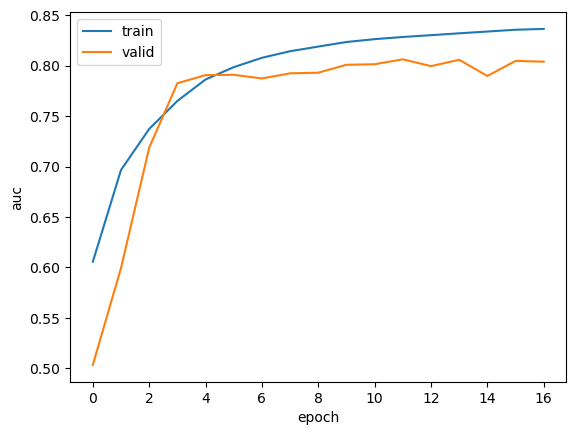

In [13]:
# create model with best params (SMOTE)

from keras.callbacks import ModelCheckpoint, EarlyStopping

model_reduced_smote = tf.keras.models.Sequential([
    tf.keras.layers.Dense(224, input_shape=[X_train_smote.shape[1]]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(480, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optim_func = Adam(learning_rate=0.001)
auc_metric = tf.keras.metrics.AUC(name='auc')
early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_optuna/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)


model_reduced_smote.compile(optimizer=optim_func, loss='binary_crossentropy', metrics=[auc_metric])

# train the model
history = model_reduced_smote.fit(X_train_smote, y_train_smote, epochs=100, batch_size=512, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint_callback])


history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [73]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

model_smote = keras.models.load_model('model/model_reduced_features_optuna/base_model_logloss_0.64_auc_0.81_checkpoint.h5')
y_pred_smote = model_smote.predict(X_test)

2953/2953 [==============================] - 5s 2ms/step


In [74]:
# using y test here
y_pred_keras_smote = y_pred_smote.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras_smote)
auc_keras_smote = auc(fpr_keras, tpr_keras)
avg_prec_score_smote = average_precision_score(y_test, y_pred_smote)

In [76]:
print("AUC SMOTE: ", auc_keras_smote)
print("Precision Score SMOTE:", avg_prec_score_smote)

AUC SMOTE:  0.8066993994230259
Precision Score SMOTE: 0.2375154172286712


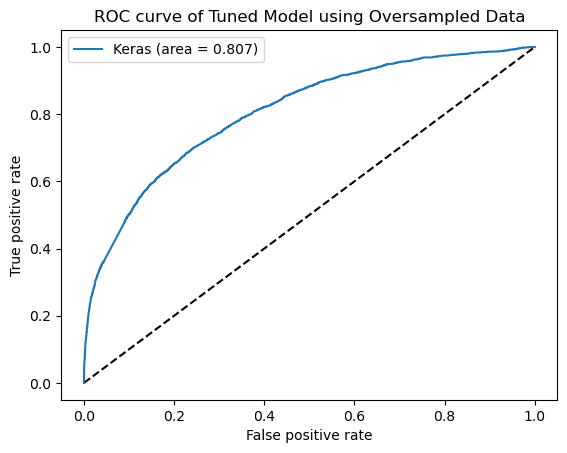

In [77]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_smote))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Tuned Model using Oversampled Data')
plt.legend(loc='best')
plt.show()

In [78]:
temp_smote = X_test.copy()
temp_smote['predicted'] = y_pred_smote
temp_smote['true'] = y_test
fraud_cases = temp_smote[temp_smote['true'] == 1]
non_fraud_cases = temp_smote[temp_smote['true']==0]
temp_smote.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,predicted,true
305217,4,42,4,2,65,31,-1.416108,0.533902,2,2,2,3,2,2,2,2,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.364092,0.320468,0
461940,4,42,4,2,65,31,0.614603,0.533902,1,0,0,2,1,0,0,1,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.403605,0.454032,0
246802,4,42,4,2,65,31,0.614603,0.533902,2,2,2,0,0,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.422421,0.498212,0
350081,2,42,4,2,65,30,0.614603,-1.833103,2,2,2,3,2,2,2,2,1.683197,-0.664176,2.095003,1.524002,-0.664404,2.457170,2.312554,-0.694394,-1.102703,-1.135389,-1.072947,1,22,1,1,59,202,83,1,1,68,163,1,0,0,2,1727,3,23,2,12,293,6,46,0.062605,0.542207,0
307850,4,42,4,2,65,31,0.614603,0.533902,1,1,1,3,2,2,2,2,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.113217,0.326549,0


In [79]:
import seaborn as sns

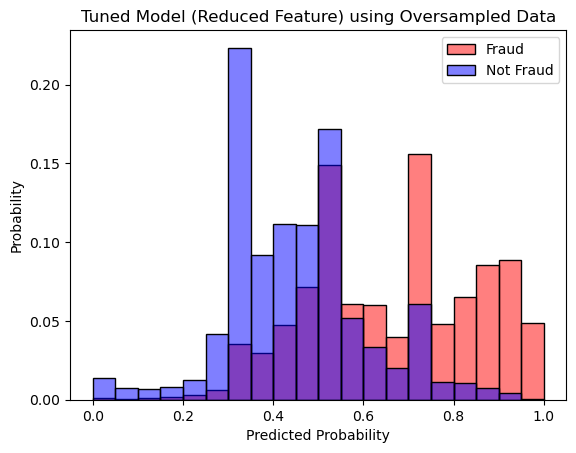

In [80]:

fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Tuned Model (Reduced Feature) using Oversampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

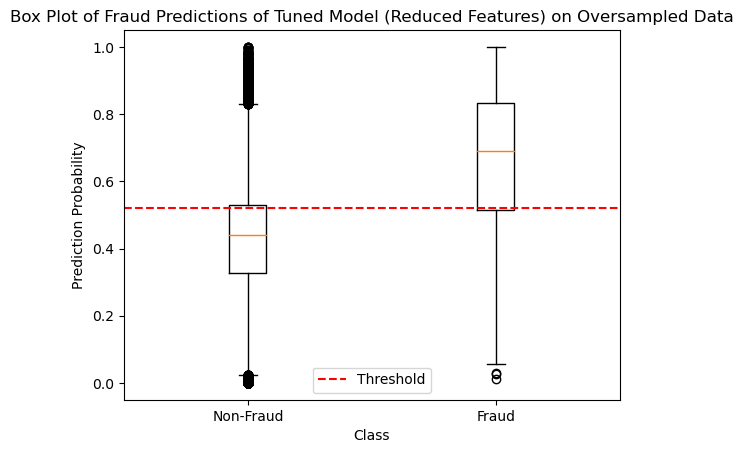

In [83]:
fraud_cases = y_pred_smote[y_test==1]
non_fraud_cases = y_pred_smote[y_test==0]
threshold = 0.52
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions of Tuned Model (Reduced Features) on Oversampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Threshold: 0.48


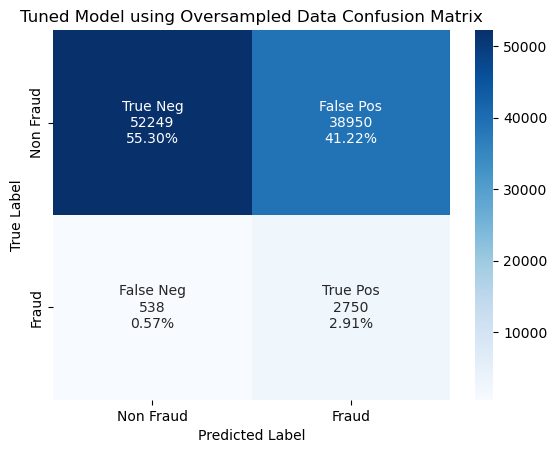

Metrics when threshold is 0.48: 
False Positive Rate: 0.4270880163159684
Recall: 0.8363746958637469
Precision: 0.06594724220623502
Accuracy: 0.5820800745076042
F1: 0.12225482350849116
AUC: 0.8066993994230259
Threshold: 0.49


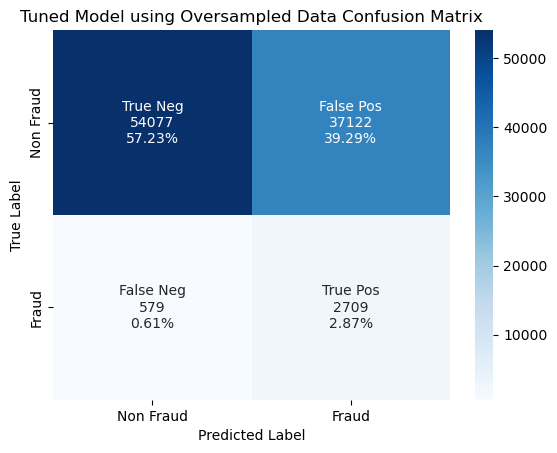

Metrics when threshold is 0.49: 
False Positive Rate: 0.40704393688527285
Recall: 0.823905109489051
Precision: 0.06801235218799427
Accuracy: 0.6009927291585085
F1: 0.1256522646629096
AUC: 0.8066993994230259
Threshold: 0.5


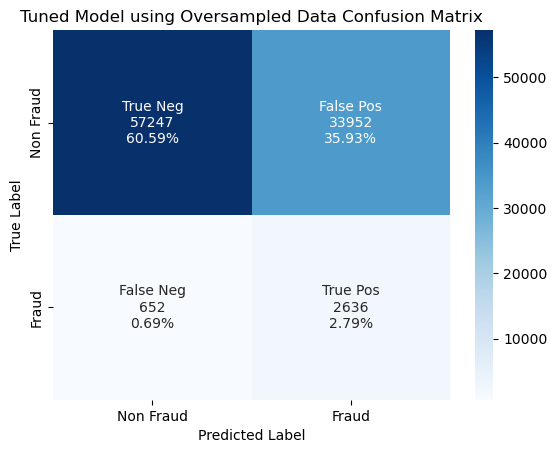

Metrics when threshold is 0.5: 
False Positive Rate: 0.372284783824384
Recall: 0.8017031630170316
Precision: 0.07204547939215043
Accuracy: 0.6337697249357055
F1: 0.13220985053666368
AUC: 0.8066993994230259
Threshold: 0.51


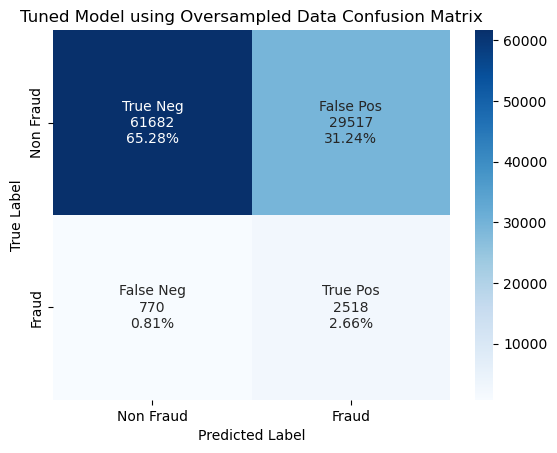

Metrics when threshold is 0.51: 
False Positive Rate: 0.32365486463667364
Recall: 0.7658150851581509
Precision: 0.07860152957702513
Accuracy: 0.679458549853419
F1: 0.1425699968858817
AUC: 0.8066993994230259
Threshold: 0.52


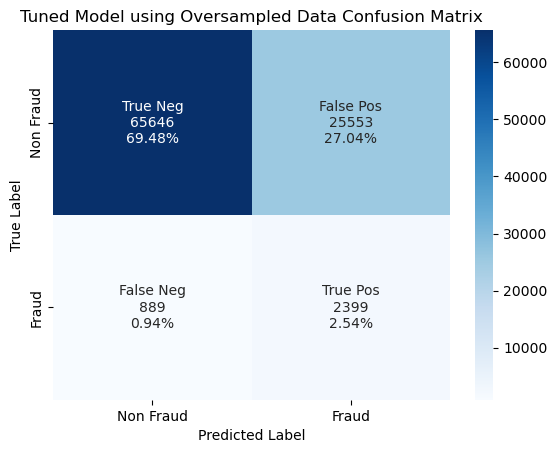

Metrics when threshold is 0.52: 
False Positive Rate: 0.28018947576179565
Recall: 0.7296228710462287
Precision: 0.08582570120206068
Accuracy: 0.7201519785790638
F1: 0.1535851472471191
AUC: 0.8066993994230259
Threshold: 0.53


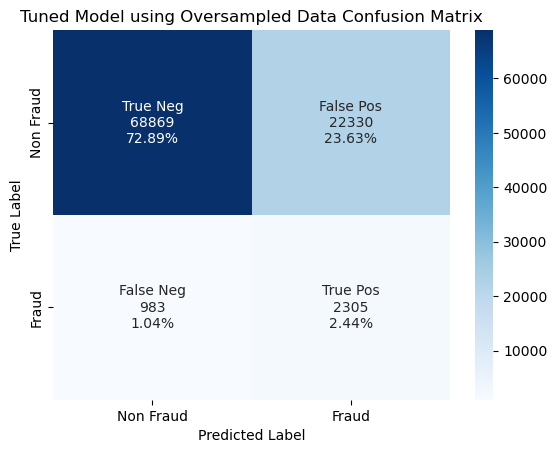

Metrics when threshold is 0.53: 
False Positive Rate: 0.24484917597780678
Recall: 0.7010340632603407
Precision: 0.09356606454231783
Accuracy: 0.7532676452845365
F1: 0.1650968735451062
AUC: 0.8066993994230259
Threshold: 0.54


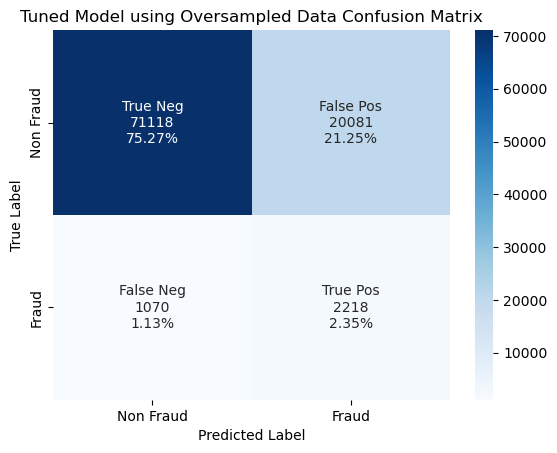

Metrics when threshold is 0.54: 
False Positive Rate: 0.22018881785984495
Recall: 0.6745742092457421
Precision: 0.09946634378223239
Accuracy: 0.7761490998761734
F1: 0.1733692890921171
AUC: 0.8066993994230259
Threshold: 0.55


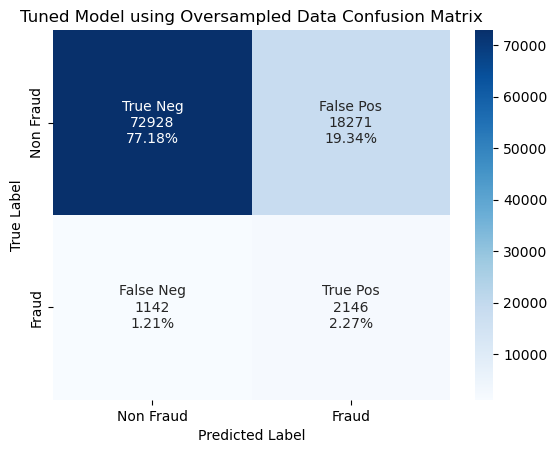

Metrics when threshold is 0.55: 
False Positive Rate: 0.20034210901435323
Recall: 0.652676399026764
Precision: 0.10510848802468531
Accuracy: 0.7945431646681554
F1: 0.1810588483442312
AUC: 0.8066993994230259
Threshold: 0.56


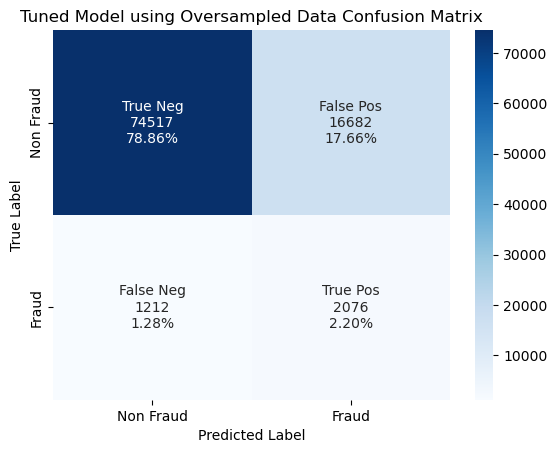

Metrics when threshold is 0.56: 
False Positive Rate: 0.18291867235386353
Recall: 0.6313868613138686
Precision: 0.11067277961403135
Accuracy: 0.8106194502947496
F1: 0.1883334845323415
AUC: 0.8066993994230259
Threshold: 0.57


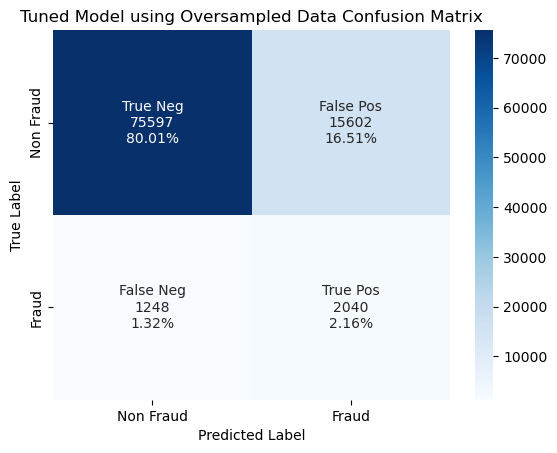

Metrics when threshold is 0.57: 
False Positive Rate: 0.17107643724163643
Recall: 0.6204379562043796
Precision: 0.11563314816914182
Accuracy: 0.8216685893297491
F1: 0.19493549928332535
AUC: 0.8066993994230259
Threshold: 0.58


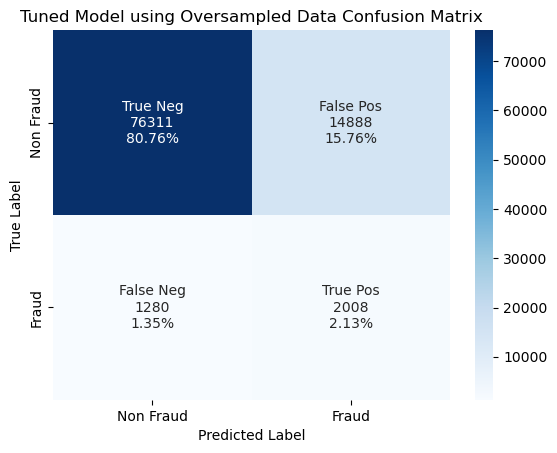

Metrics when threshold is 0.58: 
False Positive Rate: 0.16324740402855295
Recall: 0.610705596107056
Precision: 0.11884469696969698
Accuracy: 0.8288865134886281
F1: 0.19896948077685295
AUC: 0.8066993994230259
Threshold: 0.59


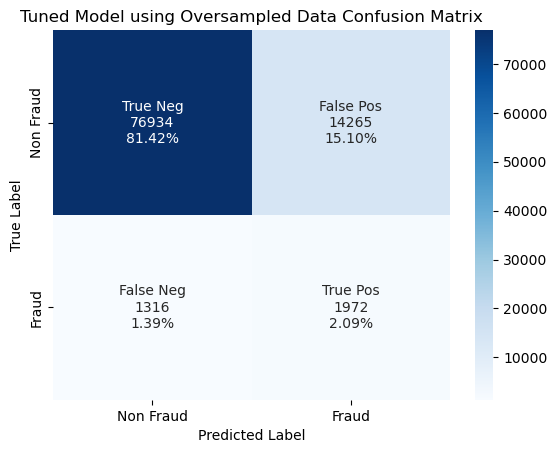

Metrics when threshold is 0.59: 
False Positive Rate: 0.1564161887739997
Recall: 0.5997566909975669
Precision: 0.12145100695941369
Accuracy: 0.8350990083291882
F1: 0.20199743918053775
AUC: 0.8066993994230259
Threshold: 0.6


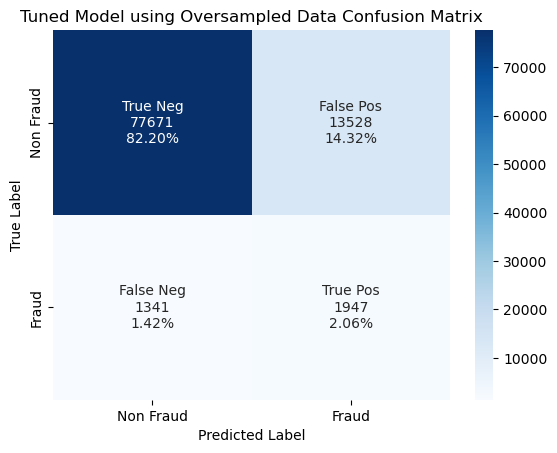

Metrics when threshold is 0.6: 
False Positive Rate: 0.14833495981315584
Recall: 0.5921532846715328
Precision: 0.12581583198707594
Accuracy: 0.8426344364833257
F1: 0.20753610829824656
AUC: 0.8066993994230259


In [122]:
import pandas as pd
threshold = [0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6]
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary = (y_pred_smote > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Oversampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    print(f"Metrics when threshold is {thresh}: ")

    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_smote}")
    print("="*80)
    
    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_smote
    }
    results.append(result)

df_result_smote = pd.DataFrame(results)


In [123]:
df_result_smote

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.48,0.427088,0.836375,0.065947,0.582080,0.122255,0.806699
1,0.49,0.407044,0.823905,0.068012,0.600993,0.125652,0.806699
2,0.50,0.372285,0.801703,0.072045,0.633770,0.132210,0.806699
3,0.51,0.323655,0.765815,0.078602,0.679459,0.142570,0.806699
4,0.52,0.280189,0.729623,0.085826,0.720152,0.153585,0.806699
5,0.53,0.244849,0.701034,0.093566,0.753268,0.165097,0.806699
6,0.54,0.220189,0.674574,0.099466,0.776149,0.173369,0.806699
7,0.55,0.200342,0.652676,0.105108,0.794543,0.181059,0.806699
8,0.56,0.182919,0.631387,0.110673,0.810619,0.188333,0.806699
9,0.57,0.171076,0.620438,0.115633,0.821669,0.194935,0.806699


# Undersampled

In [8]:
from imblearn.under_sampling import RandomUnderSampler

In [9]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f"X_train_rus shape: {X_train_rus.shape}")
print(f"y_train_rus shape: {y_train_rus.shape}")

X_train_rus shape: (28122, 51)
y_train_rus shape: (28122,)


In [10]:
import optuna
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix

In [11]:

def objective(trial):
    # Define the hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [3e-7, 1e-6, 1e-5, 1e-4, 1e-3])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    layer_units = []

    # Define the number of neurons in each layer
    for i in range(num_layers):
        layer_units.append(trial.suggest_int(f'layer_{i}_units', 64, 512, step=32))

    # Define the model architecture
    model = Sequential()
    for i, units in enumerate(layer_units):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=[X_train_rus.shape[1]]))
        else:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer with the suggested learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

    auc_metric = tf.keras.metrics.AUC(name='auc')


    # Compile the model with the specified optimizer
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=[auc_metric])

    # Define callbacks
    early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

    # Train the model
    model.fit(X_train_rus, y_train_rus, batch_size=batch_size, validation_data=(X_val, y_val), epochs=50, verbose=0, callbacks=[early_stop])

    # Predict probabilities for validation set
    y_pred_proba = model.predict(X_test)
    # y_pred_binary = (y_pred_proba > 0.4).astype(int)
    # cm = confusion_matrix(y_test, y_pred_binary)

    # Calculate the AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # # calculate recall and precision
    # tn, fp, fn, tp = cm.ravel()
    # recall = tp / (tp + fn)
    # precision = tp / (tp + fp)
    # print(recall)
    # print(precision)
    # Return both AUC and precision
    return auc_score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

[I 2023-07-01 09:48:32,587] A new study created in memory with name: no-name-be63f0de-d237-4926-94b9-f7e6a5ce62a4


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-01 09:48:35.433091: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:51:25,424] Trial 0 finished with value: 0.6613181852609741 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384, 'layer_2_units': 320, 'layer_3_units': 96}. Best is trial 0 with value: 0.6613181852609741.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:52:12,296] Trial 1 finished with value: 0.44799650247477585 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 160, 'layer_1_units': 448, 'layer_2_units': 128, 'layer_3_units': 448}. Best is trial 0 with value: 0.6613181852609741.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:52:58,436] Trial 2 finished with value: 0.7100998891117734 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 64, 'layer_2_units': 512, 'layer_3_units': 480}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:54:13,037] Trial 3 finished with value: 0.5701969692676818 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 384, 'layer_1_units': 352}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:55:11,436] Trial 4 finished with value: 0.7088122948241657 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 512, 'layer_1_units': 480}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:57:53,706] Trial 5 finished with value: 0.7788142545902867 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 352}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:02:16,575] Trial 6 finished with value: 0.3640700485895006 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 64, 'layer_2_units': 352}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 10:03:35,140] Trial 7 finished with value: 0.5774256285998356 and parameters: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 384, 'layer_2_units': 320, 'layer_3_units': 448}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:04:56,559] Trial 8 finished with value: 0.6815773884248582 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 64, 'layer_1_units': 416, 'layer_2_units': 96}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:06:36,044] Trial 9 finished with value: 0.6472090597367234 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 160, 'layer_2_units': 448}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:07:35,230] Trial 10 finished with value: 0.4894794114706885 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 10:08:25,905] Trial 11 finished with value: 0.6030004430833575 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 256, 'layer_2_units': 512}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:09:12,889] Trial 12 finished with value: 0.7197693803548076 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 128, 'layer_1_units': 64}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:10:32,017] Trial 13 finished with value: 0.7571569914394578 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 160}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:15:21,571] Trial 14 finished with value: 0.7977937921054915 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 224, 'layer_1_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:16:22,505] Trial 15 finished with value: 0.7182902298172102 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 320}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:17:54,596] Trial 16 finished with value: 0.6457898583800687 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 384, 'layer_1_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 10:19:53,578] Trial 17 finished with value: 0.4921607204175762 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:24:47,500] Trial 18 finished with value: 0.7979329409692538 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 10:27:06,765] Trial 19 finished with value: 0.7508889980145288 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 512, 'layer_1_units': 224, 'layer_2_units': 224}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:28:44,522] Trial 20 finished with value: 0.7758334698626616 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 448, 'layer_1_units': 128}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:32:01,777] Trial 21 finished with value: 0.7884516544379875 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:36:59,619] Trial 22 finished with value: 0.7908835172324024 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:41:56,609] Trial 23 finished with value: 0.799549112727444 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:43:22,095] Trial 24 finished with value: 0.7639988098937889 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 224}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:47:41,429] Trial 25 finished with value: 0.6097435995891342 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 416, 'layer_1_units': 320, 'layer_2_units': 64}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:48:47,226] Trial 26 finished with value: 0.6705195866694977 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 480, 'layer_1_units': 224}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:50:43,074] Trial 27 finished with value: 0.6200954540095722 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 352, 'layer_1_units': 128}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 11:00:14,826] Trial 28 finished with value: 0.8017549617905967 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416}. Best is trial 28 with value: 0.8017549617905967.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 11:01:51,657] Trial 29 finished with value: 0.6919448666826793 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 480, 'layer_1_units': 320, 'layer_2_units': 416}. Best is trial 28 with value: 0.8017549617905967.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:11:53,658] Trial 30 finished with value: 0.8041157786444333 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 64}. Best is trial 30 with value: 0.8041157786444333.


2953/2953 [==============================] - 10s 3ms/step


[I 2023-07-01 11:21:59,319] Trial 31 finished with value: 0.8053047843504922 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 96}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:27:02,514] Trial 32 finished with value: 0.7855248594895112 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 64}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:36:53,672] Trial 33 finished with value: 0.8037290478171194 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:46:14,572] Trial 34 finished with value: 0.8044790153555542 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:55:36,315] Trial 35 finished with value: 0.8059650824008855 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:59:42,809] Trial 36 finished with value: 0.7263557115507067 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 448, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:09:19,757] Trial 37 finished with value: 0.6969330493923491 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 128, 'layer_2_units': 352, 'layer_3_units': 160}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:11:11,367] Trial 38 finished with value: 0.6078884714928764 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 160, 'layer_2_units': 480, 'layer_3_units': 288}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:14:08,647] Trial 39 finished with value: 0.6135226306799102 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 96, 'layer_2_units': 256, 'layer_3_units': 128}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:24:12,850] Trial 40 finished with value: 0.8051066250699754 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:34:11,763] Trial 41 finished with value: 0.8041508414035038 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:43:15,028] Trial 42 finished with value: 0.8033730010725721 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 352, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:45:39,795] Trial 43 finished with value: 0.7497055998821218 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 160, 'layer_2_units': 384, 'layer_3_units': 224}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:46:43,635] Trial 44 finished with value: 0.681273685704124 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 64, 'layer_1_units': 224, 'layer_2_units': 288, 'layer_3_units': 352}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:53:26,538] Trial 45 finished with value: 0.5250636198656404 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 96, 'layer_2_units': 384, 'layer_3_units': 320}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:04:19,608] Trial 46 finished with value: 0.804678710340898 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 448, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:08:30,541] Trial 47 finished with value: 0.7528378724699487 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 224, 'layer_2_units': 448, 'layer_3_units': 160}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:20:07,899] Trial 48 finished with value: 0.8023126977691014 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 160, 'layer_2_units': 320, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:21:13,940] Trial 49 finished with value: 0.7120655529395105 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 96, 'layer_1_units': 96, 'layer_2_units': 480, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


Best params: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}
Best value for AUC: 0.8059650824008855


In [12]:
# Create a list of dictionaries containing trial information
trial_data = []
for trial in study.trials:
    trial_dict = {
        'Trial': trial.number,
        'Value (AUC Score)': trial.value,
    }
    trial_dict.update(trial.params)  # Flatten the parameters dictionary
    trial_data.append(trial_dict)

# Create a dataframe from the trial data
df = pd.DataFrame(trial_data)

In [15]:
from csv import writer
df.to_csv("hasil optuna rus optuna.csv")

In [115]:
df

,Trial,Value (AUC Score),num_layers,dropout_rate,learning_rate,optimizer,batch_size,layer_0_units,layer_1_units,layer_2_units,layer_3_units
0,0,0.661318,4,0.4,1.000000e-04,adam,64,320,384,320.0,96.0
1,1,0.447997,4,0.5,1.000000e-05,adam,512,160,448,128.0,448.0
2,2,0.710100,4,0.5,1.000000e-03,adam,256,64,64,512.0,480.0
3,3,0.570197,2,0.3,1.000000e-05,sgd,128,384,352,NaN,NaN
4,4,0.708812,2,0.2,1.000000e-05,sgd,512,512,480,NaN,NaN
5,5,0.778814,2,0.3,1.000000e-03,adam,128,256,352,NaN,NaN
6,6,0.364070,3,0.3,1.000000e-05,sgd,64,384,64,352.0,NaN
7,7,0.577426,4,0.3,1.000000e-05,adam,128,320,384,320.0,448.0
8,8,0.681577,3,0.3,1.000000e-03,sgd,128,64,416,96.0,NaN
9,9,0.647209,3,0.2,1.000000e-03,sgd,128,256,160,448.0,NaN


In [16]:
print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

Best params: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}
Best value for AUC: 0.8059650824008855


Epoch 1/100
440/440 [==============================] - ETA: 0s - loss: 3.0540 - auc: 0.5696
Epoch 1: val_auc improved from -inf to 0.69651, saving model to ./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.43_auc_0.70_checkpoint.h5
440/440 [==============================] - 39s 80ms/step - loss: 3.0540 - auc: 0.5696 - val_loss: 0.4318 - val_auc: 0.6965
Epoch 2/100
440/440 [==============================] - ETA: 0s - loss: 0.7710 - auc: 0.6084
Epoch 2: val_auc improved from 0.69651 to 0.71747, saving model to ./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.63_auc_0.72_checkpoint.h5
440/440 [==============================] - 12s 28ms/step - loss: 0.7710 - auc: 0.6084 - val_loss: 0.6297 - val_auc: 0.7175
Epoch 3/100
440/440 [==============================] - ETA: 0s - loss: 0.6909 - auc: 0.6264
Epoch 3: val_auc did not improve from 0.71747
440/440 [==============================] - 12s 28ms/step - loss: 0.6909 - auc: 0.6264 - val_loss: 0.688

<Axes: xlabel='epoch', ylabel='auc'>

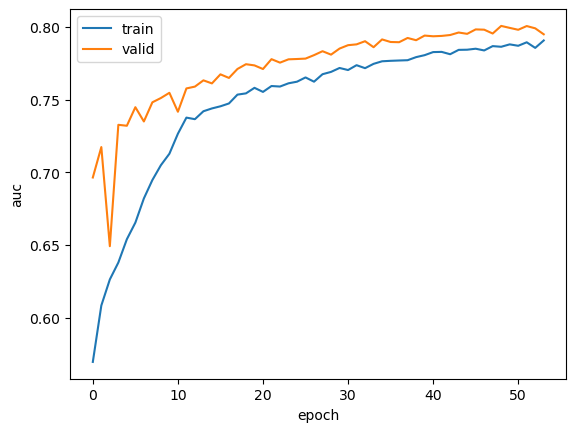

In [30]:
# create model with best params (RUS)

from keras.callbacks import ModelCheckpoint, EarlyStopping

model_reduced_rus = tf.keras.models.Sequential([
    tf.keras.layers.Dense(96, input_shape=[X_train_rus.shape[1]]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(384, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optim_func = Adam(learning_rate=0.001)
auc_metric = tf.keras.metrics.AUC(name='auc')
early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)


model_reduced_rus.compile(optimizer=optim_func, loss='binary_crossentropy', metrics=[auc_metric])

# train the model
history = model_reduced_rus.fit(X_train_rus, y_train_rus, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint_callback])


history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [104]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

model_rus = keras.models.load_model('model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.52_auc_0.80_checkpoint.h5')
y_pred_rus = model_rus.predict(X_test)

2953/2953 [==============================] - 5s 2ms/step


In [105]:
# using x test here
y_pred_keras = y_pred_rus.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_rus = auc(fpr_keras, tpr_keras)
avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

In [106]:
print("AUC RUS: ", auc_keras_rus)
print("Precision Score RUS:", avg_prec_score_rus)

AUC RUS:  0.8014763672601845
Precision Score RUS: 0.17605269449105726


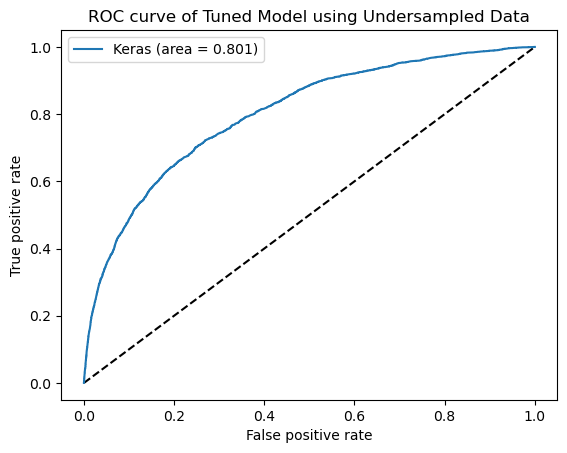

In [107]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_rus))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Tuned Model using Undersampled Data')
plt.legend(loc='best')
plt.show()

In [108]:
temp_rus = X_test.copy()
temp_rus['predicted'] = y_pred_rus
temp_rus['true'] = y_test
fraud_cases = temp_rus[temp_rus['true'] == 1]
non_fraud_cases = temp_rus[temp_rus['true']==0]
temp_rus.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,predicted,true
305217,4,42,4,2,65,31,-1.416108,0.533902,2,2,2,3,2,2,2,2,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.364092,0.169155,0
461940,4,42,4,2,65,31,0.614603,0.533902,1,0,0,2,1,0,0,1,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.403605,0.388608,0
246802,4,42,4,2,65,31,0.614603,0.533902,2,2,2,0,0,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.422421,0.427934,0
350081,2,42,4,2,65,30,0.614603,-1.833103,2,2,2,3,2,2,2,2,1.683197,-0.664176,2.095003,1.524002,-0.664404,2.457170,2.312554,-0.694394,-1.102703,-1.135389,-1.072947,1,22,1,1,59,202,83,1,1,68,163,1,0,0,2,1727,3,23,2,12,293,6,46,0.062605,0.537172,0
307850,4,42,4,2,65,31,0.614603,0.533902,1,1,1,3,2,2,2,2,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.113217,0.195516,0


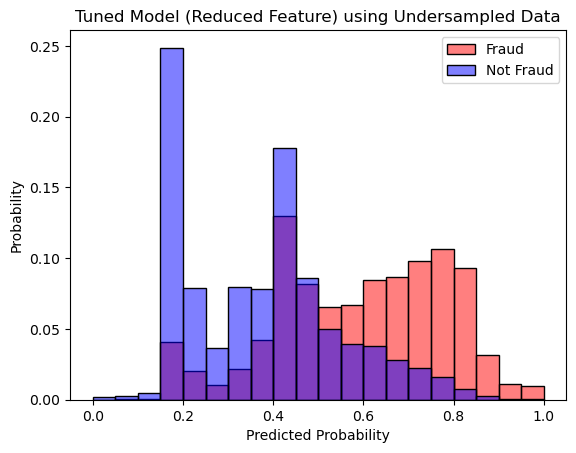

In [109]:

fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Tuned Model (Reduced Feature) using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

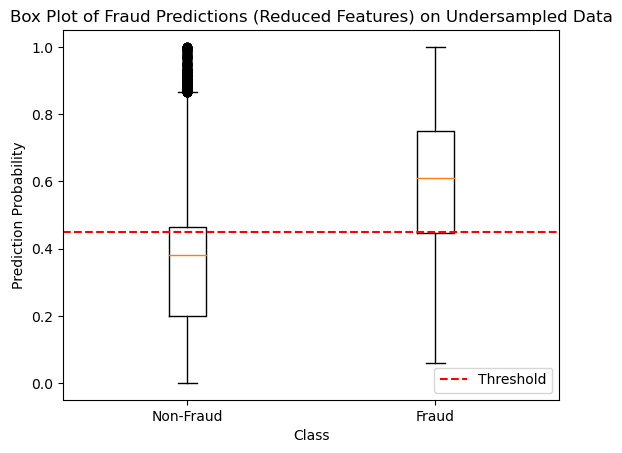

In [110]:
fraud_cases = y_pred_rus[y_test==1]
non_fraud_cases = y_pred_rus[y_test==0]
threshold = 0.45
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Threshold: 0.41


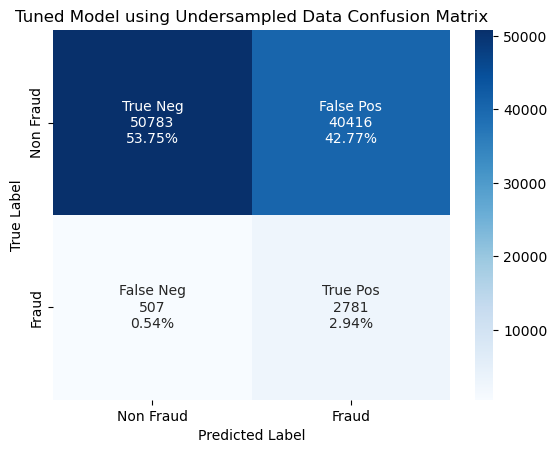

Metrics when threshold is 0.41: 

False Positive Rate: 0.44316275397756555
Recall: 0.8458029197080292
Precision: 0.0643794707965831
Accuracy: 0.5668928000677342
F1: 0.11965150048402712
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.42


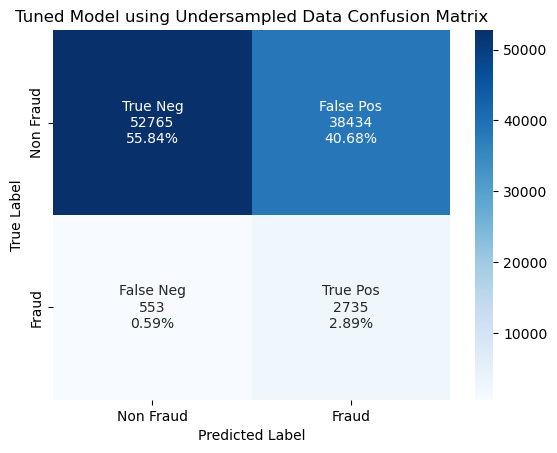

Metrics when threshold is 0.42: 

False Positive Rate: 0.4214300595401265
Recall: 0.8318126520681265
Precision: 0.0664334815030727
Accuracy: 0.587382391228423
F1: 0.12304024113188024
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.43


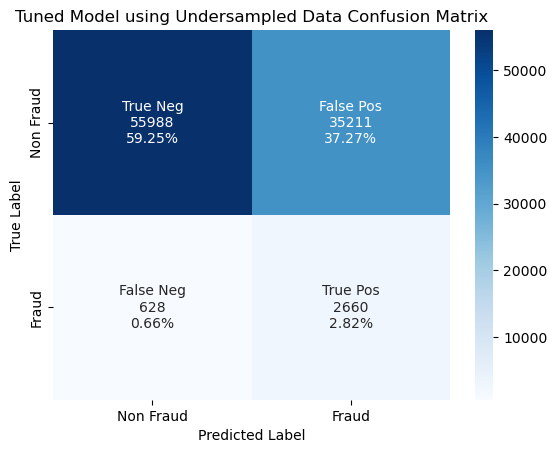

Metrics when threshold is 0.43: 

False Positive Rate: 0.3860897597561377
Recall: 0.8090024330900243
Precision: 0.07023844102347443
Accuracy: 0.6206991437975594
F1: 0.12925484098253115
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.44


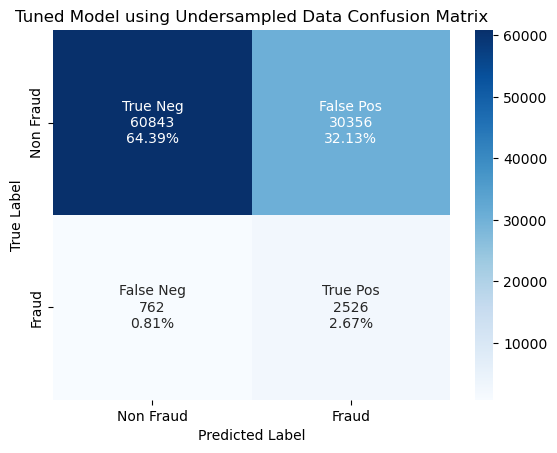

Metrics when threshold is 0.44: 

False Positive Rate: 0.3328545269136723
Recall: 0.7682481751824818
Precision: 0.0768201447600511
Accuracy: 0.6706636891847556
F1: 0.13967376278683993
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.45


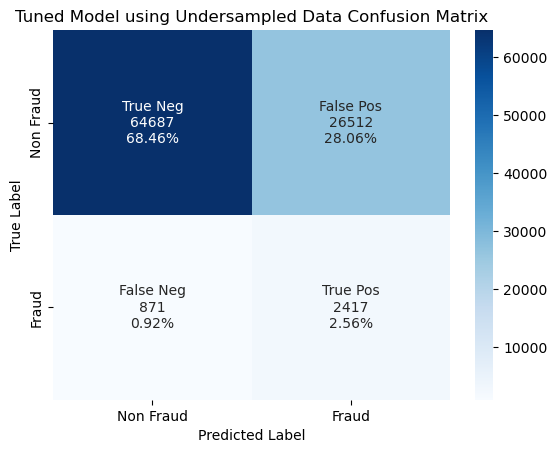

Metrics when threshold is 0.45: 

False Positive Rate: 0.29070494194015284
Recall: 0.7350973236009732
Precision: 0.0835493795153652
Accuracy: 0.7101929365944522
F1: 0.1500450072942856
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.46


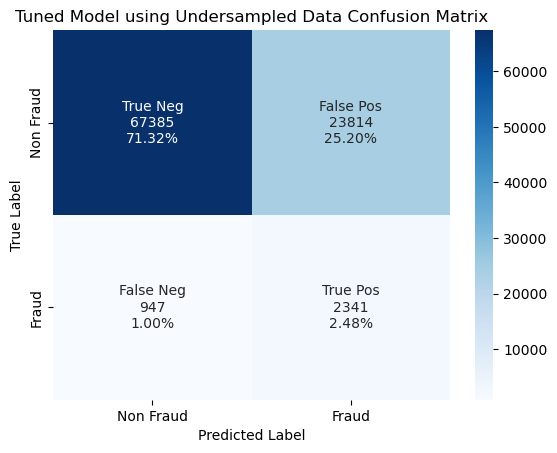

Metrics when threshold is 0.46: 

False Positive Rate: 0.26112128422460773
Recall: 0.7119829683698297
Precision: 0.08950487478493596
Accuracy: 0.7379427857800543
F1: 0.1590191216927623
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.47


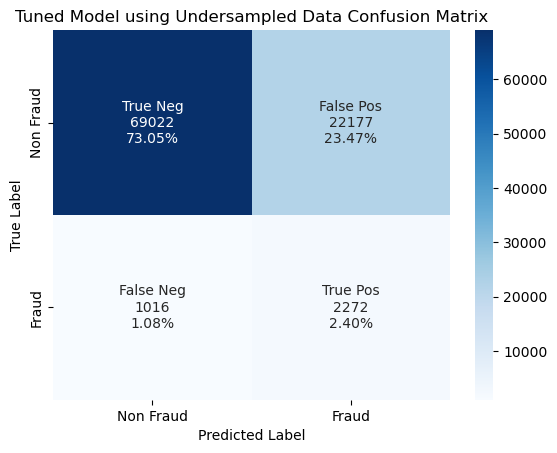

Metrics when threshold is 0.47: 

False Positive Rate: 0.2431715260035746
Recall: 0.6909975669099757
Precision: 0.09292813612008671
Accuracy: 0.754537661265571
F1: 0.16382449435771715
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.48


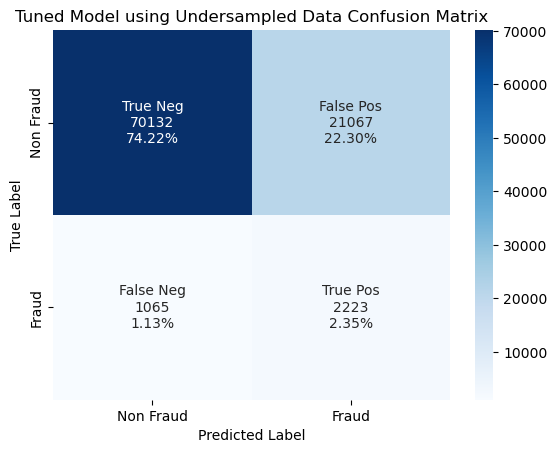

Metrics when threshold is 0.48: 

False Positive Rate: 0.23100033991600785
Recall: 0.676094890510949
Precision: 0.09544869042507514
Accuracy: 0.765766719231217
F1: 0.16728121002332758
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.49


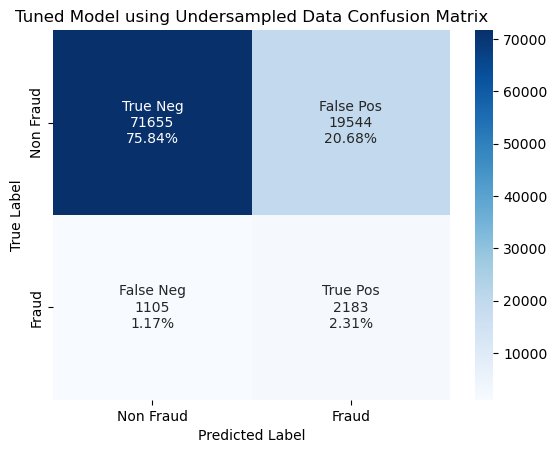

Metrics when threshold is 0.49: 

False Positive Rate: 0.21430059540126536
Recall: 0.6639294403892944
Precision: 0.10047406452800663
Accuracy: 0.7814620000635008
F1: 0.17453527883270037
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.5


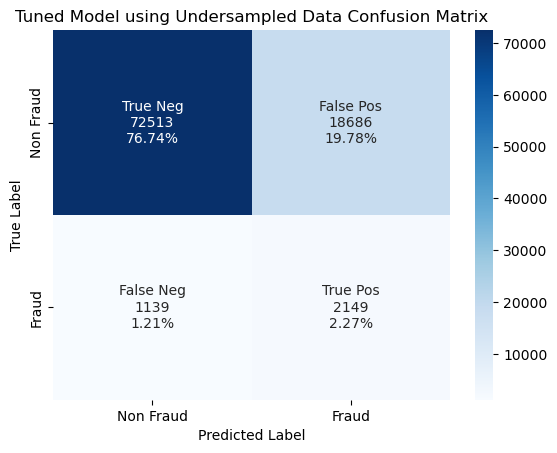

Metrics when threshold is 0.5: 

False Positive Rate: 0.20489259750655162
Recall: 0.6535888077858881
Precision: 0.10314374850012
Accuracy: 0.7901827764666038
F1: 0.17817021100194835
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726


In [133]:
threshold = [0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary_rus = (y_pred_rus > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary_rus)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Undersampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

    print(f"Metrics when threshold is {thresh}: ")
    print()
    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_rus}")
    print(f"Average Precision Score: {avg_prec_score_rus}")
    print("="*80)

    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_rus,
    }
    results.append(result)

df_result_rus = pd.DataFrame(results)

In [134]:
df_result_rus

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.41,0.443163,0.845803,0.064379,0.566893,0.119652,0.801476
1,0.42,0.421430,0.831813,0.066433,0.587382,0.123040,0.801476
2,0.43,0.386090,0.809002,0.070238,0.620699,0.129255,0.801476
3,0.44,0.332855,0.768248,0.076820,0.670664,0.139674,0.801476
4,0.45,0.290705,0.735097,0.083549,0.710193,0.150045,0.801476
5,0.46,0.261121,0.711983,0.089505,0.737943,0.159019,0.801476
6,0.47,0.243172,0.690998,0.092928,0.754538,0.163824,0.801476
7,0.48,0.231000,0.676095,0.095449,0.765767,0.167281,0.801476
8,0.49,0.214301,0.663929,0.100474,0.781462,0.174535,0.801476
9,0.50,0.204893,0.653589,0.103144,0.790183,0.178170,0.801476


In [132]:
df_result_smote

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.48,0.427088,0.836375,0.065947,0.582080,0.122255,0.806699
1,0.49,0.407044,0.823905,0.068012,0.600993,0.125652,0.806699
2,0.50,0.372285,0.801703,0.072045,0.633770,0.132210,0.806699
3,0.51,0.323655,0.765815,0.078602,0.679459,0.142570,0.806699
4,0.52,0.280189,0.729623,0.085826,0.720152,0.153585,0.806699
5,0.53,0.244849,0.701034,0.093566,0.753268,0.165097,0.806699
6,0.54,0.220189,0.674574,0.099466,0.776149,0.173369,0.806699
7,0.55,0.200342,0.652676,0.105108,0.794543,0.181059,0.806699
8,0.56,0.182919,0.631387,0.110673,0.810619,0.188333,0.806699
9,0.57,0.171076,0.620438,0.115633,0.821669,0.194935,0.806699


In [135]:
df_result_rus.to_csv('hasil threshold undersampled.csv')
df_result_smote.to_csv('hasil threshold smote.csv')